In [206]:
######################################################################################
### Perform regression of logp for small molecules obtained from the ZINC data set.
######################################################################################

# Import modules
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from rdkit import Chem
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from imp import reload
import utils
import load_ZINC_data
import data_set
from models import regression

# Set the plot style
plt.style.use('seaborn-ticks')

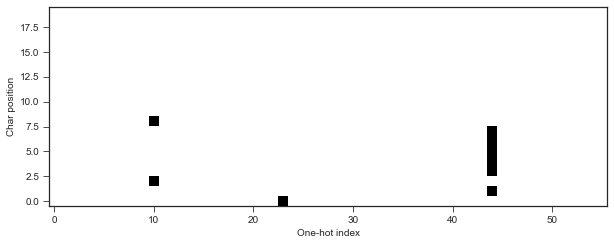

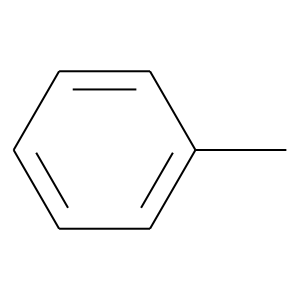

In [394]:
#####################################################################
### Test the smiles encoder
#####################################################################
reload(utils)

# Define some molecule based on its Smile representation
m = Chem.MolFromSmiles('Cc1ccccc1')

# Define a smiles encoder
smiles_encoder = utils.SmilesEncoder(max_string_length=20)

# Encode the smiles string of the molecule to a one-hot matrix
m_encoded = smiles_encoder.encode(Chem.MolToSmiles(m), flatten=False)

# Plot the encoded matrix
plt.figure(figsize=(10, 10))
plt.imshow(m_encoded, origin='lower')
plt.xlabel('One-hot index')
plt.ylabel('Char position')
plt.show()

# Now encode the smiles string of the molecule but flatten the one-hot matrix
m_encoded = smiles_encoder.encode(Chem.MolToSmiles(m), flatten=True)

# Decode the encoded vector
m_decoded = smiles_encoder.decode(m_encoded)

# Draw the decoded molecule
utils.draw_molecule(m_decoded)

In [16]:
#####################################################################
### Download some of the tranches of the ZINC data set
#####################################################################

reload(load_ZINC_data)

# Define the name (path) to the file that contains the urls of the ZINC tranches
ZINC_tranches_list_file_name = 'ZINC-downloader-2D-txt.uri'

# Define the name of the file in which we will store the data
data_file_name = 'data.pickle'

# Define the number of tranches we want to sample and a random seed
num_tranche_samples = 10
random_seed         = 151

# Load the data from the web
data_df = load_ZINC_data.load_from_web(ZINC_tranches_list_file_name, num_tranche_samples, random_seed=random_seed)

print()
print(f"Loading done")
print(f"Number of loaded molecules: {len(data_df)}")

# Store the data on disc
data_df.to_pickle(data_file_name)
print(f"Stored data in {data_file_name}")

Sample 1/10
Sample 2/10
Sample 3/10
Sample 4/10
Sample 5/10
Sample 6/10
Sample 7/10
Sample 8/10
Sample 9/10
Sample 10/10

Loading done
Number of loaded molecules: 237128


In [344]:
#####################################################################
### Define a data set object, load the data and preprocess it
#####################################################################

reload(data_set)

# Define the maximum length of the (smiles) strings
# Remark: Only use molecules with a smiles string smaller
#         than this maximal length. This will restrict the
#         dimensionality of the encoded smiles string vector.
max_string_length = 25

# Define the data filter dictionary
data_filter_dict = {
    'which': 'max_string_length_cutoff',
    'params': {'max_string_length': max_string_length},
}

# Define the encoding dictionary
x_encoding_dict = {
    'which': 'one_hot', 
    'params': {'max_string_length': max_string_length},
}

# Define the transformations
# x: Transform one-hot encoded vector from values with {0, 1} to values of {-0.5, 0.5}
transformations_x = [('*', 2), ('-', 1), ('/', 2)]
# y: Standardize the data
transformations_y = 'normalize'

# Initialize the data set
# Remark: Use 'logp' of the molecules as the y label
dataset = data_set.CustomDataset(data_dir=data_file_name, 
                                 x_encoding_dict=x_encoding_dict, 
                                 y_label='logp', 
                                 data_filter_dict=data_filter_dict,
                                 transformations_x=transformations_x,
                                 transformations_y=transformations_y)


Loaded data from 'data.pickle'.
Filtered the data using 'max_string_length_cutoff' method.
Reduction from 184527 to 117317 data items.
Generate encoding of x ...
Encoding done.



In [373]:
########################################################################################################
### Split the data in train, validation (val) and test sets and define the corresponding data loaders
########################################################################################################

reload(regression)

# Define the test and validation ratios; use train/val/test=0.6/0.2/0.2
val_size  = 0.2
test_size = 0.2

# Define the random state (seed) for the splitting
random_state_splitting = 42

# Define the batch size for the loaders
batch_size = 64

# Split dataset into train and validation using stratification on the targets
# Step 1: Split full set of indices into train+val and test indices
train_val_indices, test_indices = train_test_split(list(range(len(dataset.y))), 
                                                   test_size=test_size, 
                                                   stratify=dataset.y, 
                                                   random_state=random_state_splitting)
# Step 2: Split train+val indices into train and val indices
train_indices, val_indices = train_test_split(list(range(len(dataset.y[train_val_indices]))), 
                                              test_size=val_size/(1-test_size),
                                              stratify=dataset.y[train_val_indices], 
                                              random_state=random_state_splitting)

# Generate the different datasets from the indices
dataset_dict = dict() 
dataset_dict['train'] = torch.utils.data.Subset(dataset, train_indices)
dataset_dict['val']   = torch.utils.data.Subset(dataset, val_indices)
dataset_dict['test']  = torch.utils.data.Subset(dataset, test_indices)

# Create the data loaders
dataloader_dict = dict()
for key in dataset_dict:
    dataloader_dict[key] = torch.utils.data.DataLoader(dataset_dict[key], batch_size=batch_size, shuffle=True)

# Define random seed
torch.manual_seed(42)
    
# Initialize the network object
net = regression.LogpNet(dataset.x_dim, dataset.y_dim)

# Define the loss function
def loss_func(y_data, y_pred):
    """ Define a loss criterion. """
    # Use the Mean Square Error as loss, while summing over the badges
    MSE = nn.MSELoss(reduction='sum')
    return MSE(y_data, y_pred)
    
# Use Adam as optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Define an evaluation metric
def eval_metric(y_data, y_pred):
    """ Define an evaluation metric. """
    # Use the Mean Square Error as loss, while averaging over the badges
    MSE = nn.MSELoss(reduction='mean')
    return MSE(y_data, y_pred)



[0-99] Loss: 0.03925865041092038
[0-199] Loss: 0.03892530618235469
[0-299] Loss: 0.037911766450852154
[0-399] Loss: 0.037288194000720976
[0-499] Loss: 0.03692505922168493
[0-599] Loss: 0.03795604521408677
[0-699] Loss: 0.03918584017083049
[0-799] Loss: 0.04046816520392895
[0-899] Loss: 0.03722333185374737
[0-999] Loss: 0.03931003989651799
[0-1099] Loss: 0.03768785094842315
----------------------------------------------------------------------
Epoch 0 summary:
[0] Metric (train): 0.0005997287108171307
[0] Metric (val): 0.0006516349859718406
----------------------------------------------------------------------
[1-99] Loss: 0.038259622231125834
[1-199] Loss: 0.03982281455770135
[1-299] Loss: 0.03874365406110883
[1-399] Loss: 0.037696942836046216
[1-499] Loss: 0.0376967041939497
[1-599] Loss: 0.03663148004561663
[1-699] Loss: 0.03868396921083331
[1-799] Loss: 0.0374714171141386
[1-899] Loss: 0.03864370562136173
[1-999] Loss: 0.03860870659351349
[1-1099] Loss: 0.03761024963110685
---------

[13-499] Loss: 0.03716904915869236
[13-599] Loss: 0.03651121510192752
[13-699] Loss: 0.03835797755047679
[13-799] Loss: 0.03682197753340006
[13-899] Loss: 0.03904570858925581
[13-999] Loss: 0.04033831814303994
[13-1099] Loss: 0.03648943891748786
----------------------------------------------------------------------
Epoch 13 summary:
[13] Metric (train): 0.0005933757276612927
[13] Metric (val): 0.0006711181575636702
----------------------------------------------------------------------
[14-99] Loss: 0.039592139050364496
[14-199] Loss: 0.03829144837334752
[14-299] Loss: 0.03875870231539011
[14-399] Loss: 0.03676928190514445
[14-499] Loss: 0.03716040678322315
[14-599] Loss: 0.03891714101657271
[14-699] Loss: 0.038386984523385764
[14-799] Loss: 0.03697219295427203
[14-899] Loss: 0.03762094150297344
[14-999] Loss: 0.0379971550963819
[14-1099] Loss: 0.03810737879946828
----------------------------------------------------------------------
Epoch 14 summary:
[14] Metric (train): 0.000594655357

[26-499] Loss: 0.03745120543986559
[26-599] Loss: 0.03942895805463195
[26-699] Loss: 0.036308893319219354
[26-799] Loss: 0.038632524590939285
[26-899] Loss: 0.03953705931082368
[26-999] Loss: 0.03710025157779455
[26-1099] Loss: 0.03903152108192444
----------------------------------------------------------------------
Epoch 26 summary:
[26] Metric (train): 0.0005938046326363375
[26] Metric (val): 0.0007912470468723441
----------------------------------------------------------------------
[27-99] Loss: 0.03889380116015673
[27-199] Loss: 0.03665458085015416
[27-299] Loss: 0.03793782625347376
[27-399] Loss: 0.03859881903976202
[27-499] Loss: 0.03866225054487586
[27-599] Loss: 0.038916184715926644
[27-699] Loss: 0.03571033531799912
[27-799] Loss: 0.03803596569225192
[27-899] Loss: 0.0377709323912859
[27-999] Loss: 0.03901548616588116
[27-1099] Loss: 0.03803814033046365
----------------------------------------------------------------------
Epoch 27 summary:
[27] Metric (train): 0.00059415586

[39-599] Loss: 0.036767508955672386
[39-699] Loss: 0.036438205596059564
[39-799] Loss: 0.037760592866688966
[39-899] Loss: 0.03862768966704607
[39-999] Loss: 0.03956579118967056
[39-1099] Loss: 0.036988066025078294
----------------------------------------------------------------------
Epoch 39 summary:
[39] Metric (train): 0.0005905019127451603
[39] Metric (val): 0.0006084226517353145
----------------------------------------------------------------------
[40-99] Loss: 0.036486936081200835
[40-199] Loss: 0.038297616485506294
[40-299] Loss: 0.03688822764903307
[40-399] Loss: 0.039188375305384396
[40-499] Loss: 0.037215413078665736
[40-599] Loss: 0.03918283496052027
[40-699] Loss: 0.03623597702011466
[40-799] Loss: 0.03667110402137041
[40-899] Loss: 0.03654732417315245
[40-999] Loss: 0.03869798442348838
[40-1099] Loss: 0.03916538629680872
----------------------------------------------------------------------
Epoch 40 summary:
[40] Metric (train): 0.0005889711776399054
[40] Metric (val): 0

[52-599] Loss: 0.037546449452638624
[52-699] Loss: 0.0372220410592854
[52-799] Loss: 0.0361110314168036
[52-899] Loss: 0.036094697341322896
[52-999] Loss: 0.039035236071795223
[52-1099] Loss: 0.03739070160314441
----------------------------------------------------------------------
Epoch 52 summary:
[52] Metric (train): 0.0005969736734616825
[52] Metric (val): 0.0007405460211676761
----------------------------------------------------------------------
[53-99] Loss: 0.03989024113863707
[53-199] Loss: 0.03726751917973161
[53-299] Loss: 0.03976975103840232
[53-399] Loss: 0.03558546317741275
[53-499] Loss: 0.03849493028596043
[53-599] Loss: 0.03827443605288863
[53-699] Loss: 0.035433547589927915
[53-799] Loss: 0.036625216845422984
[53-899] Loss: 0.037196098528802395
[53-999] Loss: 0.03722012562677264
[53-1099] Loss: 0.038176581487059595
----------------------------------------------------------------------
Epoch 53 summary:
[53] Metric (train): 0.0005880709531166675
[53] Metric (val): 0.00

[65-599] Loss: 0.0372556933760643
[65-699] Loss: 0.03703212924301624
[65-799] Loss: 0.03701147800311446
[65-899] Loss: 0.03825971517711878
[65-999] Loss: 0.03842572698369622
[65-1099] Loss: 0.040420267283916476
----------------------------------------------------------------------
Epoch 65 summary:
[65] Metric (train): 0.0005926122294675389
[65] Metric (val): 0.0006281119362579288
----------------------------------------------------------------------
[66-99] Loss: 0.035309020057320596
[66-199] Loss: 0.039383423365652565
[66-299] Loss: 0.03621723536401987
[66-399] Loss: 0.038779932279139756
[66-499] Loss: 0.0378094725497067
[66-599] Loss: 0.03932339875027537
[66-699] Loss: 0.03784521900117397
[66-799] Loss: 0.03647827550768852
[66-899] Loss: 0.038286884240806104
[66-999] Loss: 0.03817442765459418
[66-1099] Loss: 0.03807116232812405
----------------------------------------------------------------------
Epoch 66 summary:
[66] Metric (train): 0.0005905564676504582
[66] Metric (val): 0.0006

[78-599] Loss: 0.03811182303354144
[78-699] Loss: 0.03855009209364653
[78-799] Loss: 0.04096253577619791
[78-899] Loss: 0.03817675350233912
[78-999] Loss: 0.038109380453825
[78-1099] Loss: 0.03658696342259646
----------------------------------------------------------------------
Epoch 78 summary:
[78] Metric (train): 0.0005896305005510592
[78] Metric (val): 0.0006864747963211314
----------------------------------------------------------------------
[79-99] Loss: 0.0389170147664845
[79-199] Loss: 0.03868186013773084
[79-299] Loss: 0.03750581882894039
[79-399] Loss: 0.03831260751932859
[79-499] Loss: 0.03732458399608731
[79-599] Loss: 0.037932097502052786
[79-699] Loss: 0.038381657116115096
[79-799] Loss: 0.036550638750195506
[79-899] Loss: 0.03584124753251672
[79-999] Loss: 0.03858566472306848
[79-1099] Loss: 0.03804497115314007
----------------------------------------------------------------------
Epoch 79 summary:
[79] Metric (train): 0.0005911026628349315
[79] Metric (val): 0.0006437

[91-599] Loss: 0.0391144840605557
[91-699] Loss: 0.04027669068425894
[91-799] Loss: 0.035944710001349446
[91-899] Loss: 0.03746953122317791
[91-999] Loss: 0.03522203085944056
[91-1099] Loss: 0.037882838118821385
----------------------------------------------------------------------
Epoch 91 summary:
[91] Metric (train): 0.00058849736754465
[91] Metric (val): 0.0006514293802565862
----------------------------------------------------------------------
[92-99] Loss: 0.039300185292959214
[92-199] Loss: 0.037674292903393504
[92-299] Loss: 0.036065392568707465
[92-399] Loss: 0.0368533424846828
[92-499] Loss: 0.037493771463632586
[92-599] Loss: 0.038849735278636215
[92-699] Loss: 0.037531576715409756
[92-799] Loss: 0.038267060667276385
[92-899] Loss: 0.03829994285479188
[92-999] Loss: 0.03695835076272488
[92-1099] Loss: 0.036137190740555526
----------------------------------------------------------------------
Epoch 92 summary:
[92] Metric (train): 0.000587360581504816
[92] Metric (val): 0.00

[104-399] Loss: 0.038819285985082386
[104-499] Loss: 0.03816686475649476
[104-599] Loss: 0.037114093750715255
[104-699] Loss: 0.03775662779808044
[104-799] Loss: 0.038975242897868155
[104-899] Loss: 0.03831654129549861
[104-999] Loss: 0.038208170030266046
[104-1099] Loss: 0.03605447448790074
----------------------------------------------------------------------
Epoch 104 summary:
[104] Metric (train): 0.0005888661369681358
[104] Metric (val): 0.0005937611540032129
----------------------------------------------------------------------
[105-99] Loss: 0.03716400530189276
[105-199] Loss: 0.03946283273398876
[105-299] Loss: 0.038297872003167865
[105-399] Loss: 0.03969541585072875
[105-499] Loss: 0.038005593102425336
[105-599] Loss: 0.03921303858980536
[105-699] Loss: 0.03908819511532784
[105-799] Loss: 0.03702286098152399
[105-899] Loss: 0.03681247763335705
[105-999] Loss: 0.036086223069578406
[105-1099] Loss: 0.037662583962082864
------------------------------------------------------------

[117-99] Loss: 0.03809352245181799
[117-199] Loss: 0.037486624233424665
[117-299] Loss: 0.03682601938024163
[117-399] Loss: 0.03796225329861045
[117-499] Loss: 0.038098810613155364
[117-599] Loss: 0.03661896292120218
[117-699] Loss: 0.03640810452401638
[117-799] Loss: 0.03655745031312108
[117-899] Loss: 0.03620005762204528
[117-999] Loss: 0.03800522139295936
[117-1099] Loss: 0.036962330006062985
----------------------------------------------------------------------
Epoch 117 summary:
[117] Metric (train): 0.0005813992181951603
[117] Metric (val): 0.0006277344680622179
----------------------------------------------------------------------
[118-99] Loss: 0.03833548026159406
[118-199] Loss: 0.03913946894928813
[118-299] Loss: 0.03954565515741706
[118-399] Loss: 0.036730091031640766
[118-499] Loss: 0.0370859826169908
[118-599] Loss: 0.03908556239679456
[118-699] Loss: 0.03785101441666484
[118-799] Loss: 0.039379624836146834
[118-899] Loss: 0.038110606241971254
[118-999] Loss: 0.03516780210

[129] Metric (val): 0.0006371484932201668
----------------------------------------------------------------------
[130-99] Loss: 0.037283436413854364
[130-199] Loss: 0.03776476996019482
[130-299] Loss: 0.037791895195841786
[130-399] Loss: 0.03701307201758027
[130-499] Loss: 0.03784808676689863
[130-599] Loss: 0.036750034764409065
[130-699] Loss: 0.03898203568533063
[130-799] Loss: 0.037784789856523275
[130-899] Loss: 0.03625453237444162
[130-999] Loss: 0.03769432280212641
[130-1099] Loss: 0.037308288644999264
----------------------------------------------------------------------
Epoch 130 summary:
[130] Metric (train): 0.0005859860760921782
[130] Metric (val): 0.0005983560785717187
----------------------------------------------------------------------
[131-99] Loss: 0.038567180819809435
[131-199] Loss: 0.039470105692744256
[131-299] Loss: 0.03732733909040689
[131-399] Loss: 0.037768835015594956
[131-499] Loss: 0.036466957479715345
[131-599] Loss: 0.036507149152457716
[131-699] Loss: 0.0

[142-999] Loss: 0.03882840476930141
[142-1099] Loss: 0.03592803042382002
----------------------------------------------------------------------
Epoch 142 summary:
[142] Metric (train): 0.0005841377274059182
[142] Metric (val): 0.0005902029672727669
----------------------------------------------------------------------
[143-99] Loss: 0.03688232090324164
[143-199] Loss: 0.03700087919831276
[143-299] Loss: 0.03734994571655989
[143-399] Loss: 0.03775598954409361
[143-499] Loss: 0.03665591949597001
[143-599] Loss: 0.038631331883370874
[143-699] Loss: 0.038274561297148464
[143-799] Loss: 0.03891308518126607
[143-899] Loss: 0.03588889334350824
[143-999] Loss: 0.03517781391739845
[143-1099] Loss: 0.03686710426583886
----------------------------------------------------------------------
Epoch 143 summary:
[143] Metric (train): 0.0005816246804103933
[143] Metric (val): 0.0005982982736856141
----------------------------------------------------------------------
[144-99] Loss: 0.035606045704334975

[155-499] Loss: 0.03722083359956741
[155-599] Loss: 0.036632655560970305
[155-699] Loss: 0.03823957182466984
[155-799] Loss: 0.03738092156127095
[155-899] Loss: 0.039392892960458996
[155-999] Loss: 0.03598238313570619
[155-1099] Loss: 0.03662833992391825
----------------------------------------------------------------------
Epoch 155 summary:
[155] Metric (train): 0.0005871957540512085
[155] Metric (val): 0.0006006310130241111
----------------------------------------------------------------------
[156-99] Loss: 0.03697558401152492
[156-199] Loss: 0.036090760231018065
[156-299] Loss: 0.03646201698109507
[156-399] Loss: 0.037747878860682246
[156-499] Loss: 0.03795923689380288
[156-599] Loss: 0.03722968801856041
[156-699] Loss: 0.03801155522465706
[156-799] Loss: 0.03793855102732777
[156-899] Loss: 0.037592791486531496
[156-999] Loss: 0.038027875386178495
[156-1099] Loss: 0.036502378340810535
----------------------------------------------------------------------
Epoch 156 summary:
[156] M

[168-99] Loss: 0.0366850321367383
[168-199] Loss: 0.03790290482342243
[168-299] Loss: 0.038993722144514326
[168-399] Loss: 0.039168490879237655
[168-499] Loss: 0.03719277864322066
[168-599] Loss: 0.03659330029040575
[168-699] Loss: 0.03683430645614862
[168-799] Loss: 0.03774455601349473
[168-899] Loss: 0.03823266411200166
[168-999] Loss: 0.03841315645724535
[168-1099] Loss: 0.03577393481507898
----------------------------------------------------------------------
Epoch 168 summary:
[168] Metric (train): 0.0005875095471856184
[168] Metric (val): 0.0006384087748043949
----------------------------------------------------------------------
[169-99] Loss: 0.038046411965042354
[169-199] Loss: 0.038488541971892117
[169-299] Loss: 0.03516612844541669
[169-399] Loss: 0.03804784381762147
[169-499] Loss: 0.03845257516950369
[169-599] Loss: 0.036784533392637965
[169-699] Loss: 0.038042318001389505
[169-799] Loss: 0.0372434888035059
[169-899] Loss: 0.03622657954692841
[169-999] Loss: 0.037490000147

[180] Metric (val): 0.0006566089098988867
----------------------------------------------------------------------
[181-99] Loss: 0.03544312605634332
[181-199] Loss: 0.036909496635198595
[181-299] Loss: 0.03718817098066211
[181-399] Loss: 0.038854028284549716
[181-499] Loss: 0.0372225534170866
[181-599] Loss: 0.03505822362378239
[181-699] Loss: 0.0369171460159123
[181-799] Loss: 0.03852934289723635
[181-899] Loss: 0.03832899745553732
[181-999] Loss: 0.037678584195673465
[181-1099] Loss: 0.039953584242612125
----------------------------------------------------------------------
Epoch 181 summary:
[181] Metric (train): 0.0005854568724912083
[181] Metric (val): 0.0006404878564968157
----------------------------------------------------------------------
[182-99] Loss: 0.037269873227924105
[182-199] Loss: 0.03665272001177072
[182-299] Loss: 0.037760020419955256
[182-399] Loss: 0.036289435382932424
[182-499] Loss: 0.03808161947876215
[182-599] Loss: 0.03709038466215134
[182-699] Loss: 0.037355

[193-1099] Loss: 0.037134925480931995
----------------------------------------------------------------------
Epoch 193 summary:
[193] Metric (train): 0.0005835514191792092
[193] Metric (val): 0.0006496087731717393
----------------------------------------------------------------------
[194-99] Loss: 0.03638599478639662
[194-199] Loss: 0.037739910408854487
[194-299] Loss: 0.038797191251069306
[194-399] Loss: 0.03642761871218681
[194-499] Loss: 0.037463026344776156
[194-599] Loss: 0.03782459484413266
[194-699] Loss: 0.035504374075680974
[194-799] Loss: 0.03667163459584117
[194-899] Loss: 0.03806335780769587
[194-999] Loss: 0.04059836601838469
[194-1099] Loss: 0.037343580089509484
----------------------------------------------------------------------
Epoch 194 summary:
[194] Metric (train): 0.0005864554192653899
[194] Metric (val): 0.0006018347301639678
----------------------------------------------------------------------
[195-99] Loss: 0.038019814044237134
[195-199] Loss: 0.0381927445903

[206-599] Loss: 0.038892170060425994
[206-699] Loss: 0.037235774993896485
[206-799] Loss: 0.03779861671850085
[206-899] Loss: 0.03624788055196405
[206-999] Loss: 0.03741075549274683
[206-1099] Loss: 0.03463450340554118
----------------------------------------------------------------------
Epoch 206 summary:
[206] Metric (train): 0.0005825280915649438
[206] Metric (val): 0.000585382139485974
----------------------------------------------------------------------
[207-99] Loss: 0.03580634256824851
[207-199] Loss: 0.03728299664333463
[207-299] Loss: 0.03715251525864005
[207-399] Loss: 0.036775137335062026
[207-499] Loss: 0.03848669219762087
[207-599] Loss: 0.0372067429870367
[207-699] Loss: 0.03598008584231138
[207-799] Loss: 0.038590667601674795
[207-899] Loss: 0.03823595421388745
[207-999] Loss: 0.03580647610127926
[207-1099] Loss: 0.03785654298961163
----------------------------------------------------------------------
Epoch 207 summary:
[207] Metric (train): 0.0005813515625777654
[207

[219-99] Loss: 0.04006474571302533
[219-199] Loss: 0.03604987820610404
[219-299] Loss: 0.03696449495851994
[219-399] Loss: 0.03712131755426526
[219-499] Loss: 0.03642045419663191
[219-599] Loss: 0.036619995050132276
[219-699] Loss: 0.036090198401361705
[219-799] Loss: 0.035464199129492044
[219-899] Loss: 0.03850851252675056
[219-999] Loss: 0.036881675198674205
[219-1099] Loss: 0.036982500776648525
----------------------------------------------------------------------
Epoch 219 summary:
[219] Metric (train): 0.0005784266551067545
[219] Metric (val): 0.0006184823085758226
----------------------------------------------------------------------
[220-99] Loss: 0.03731869423761964
[220-199] Loss: 0.035538440477102994
[220-299] Loss: 0.0362637210264802
[220-399] Loss: 0.03899913495406508
[220-499] Loss: 0.037778545767068863
[220-599] Loss: 0.03757122291252017
[220-699] Loss: 0.03829582585021853
[220-799] Loss: 0.03577111024409532
[220-899] Loss: 0.038857915345579384
[220-999] Loss: 0.036644610

[231] Metric (val): 0.0005907976682829526
----------------------------------------------------------------------
[232-99] Loss: 0.03657312221825123
[232-199] Loss: 0.03705803001299501
[232-299] Loss: 0.03792554015293717
[232-399] Loss: 0.03609032239764929
[232-499] Loss: 0.03661627912893892
[232-599] Loss: 0.03644709857180715
[232-699] Loss: 0.03638819882646203
[232-799] Loss: 0.036230836845934394
[232-899] Loss: 0.03808221850544214
[232-999] Loss: 0.03690359903499484
[232-1099] Loss: 0.036402746699750424
----------------------------------------------------------------------
Epoch 232 summary:
[232] Metric (train): 0.000574963330635166
[232] Metric (val): 0.0006014758478171302
----------------------------------------------------------------------
[233-99] Loss: 0.03794344525784254
[233-199] Loss: 0.03640590978786349
[233-299] Loss: 0.036000212710350754
[233-399] Loss: 0.03763043187558651
[233-499] Loss: 0.03620240319520235
[233-599] Loss: 0.03795382995158434
[233-699] Loss: 0.036059505

[244-1099] Loss: 0.03655015263706446
----------------------------------------------------------------------
Epoch 244 summary:
[244] Metric (train): 0.0005857390661946159
[244] Metric (val): 0.0005969503455591066
----------------------------------------------------------------------
[245-99] Loss: 0.03756191708147526
[245-199] Loss: 0.037106917165219785
[245-299] Loss: 0.03636620873585343
[245-399] Loss: 0.03511957285925746
[245-499] Loss: 0.03754148418083787
[245-599] Loss: 0.03636032009497285
[245-699] Loss: 0.0369969254732132
[245-799] Loss: 0.03988092340528965
[245-899] Loss: 0.03584394009783864
[245-999] Loss: 0.03839720856398344
[245-1099] Loss: 0.03819164708256721
----------------------------------------------------------------------
Epoch 245 summary:
[245] Metric (train): 0.0005815909202581017
[245] Metric (val): 0.0006094713475204984
----------------------------------------------------------------------
[246-99] Loss: 0.03635657394304872
[246-199] Loss: 0.0352929063141346
[24

[257-599] Loss: 0.03625356586650014
[257-699] Loss: 0.03993489891290665
[257-799] Loss: 0.03699937118217349
[257-899] Loss: 0.03503378745168448
[257-999] Loss: 0.03701488530263305
[257-1099] Loss: 0.03520669016987085
----------------------------------------------------------------------
Epoch 257 summary:
[257] Metric (train): 0.0005860809643953954
[257] Metric (val): 0.0005736818299368684
----------------------------------------------------------------------
[258-99] Loss: 0.03536287203431129
[258-199] Loss: 0.03862355699762702
[258-299] Loss: 0.03676660308614373
[258-399] Loss: 0.038642126247286794
[258-499] Loss: 0.03878943840041757
[258-599] Loss: 0.03756541771814227
[258-699] Loss: 0.03819775791838765
[258-799] Loss: 0.03643517069518566
[258-899] Loss: 0.03724729223176837
[258-999] Loss: 0.03628980526700616
[258-1099] Loss: 0.035359696354717016
----------------------------------------------------------------------
Epoch 258 summary:
[258] Metric (train): 0.0005814580981280994
[258

[270-99] Loss: 0.03694907043129206
[270-199] Loss: 0.03582996876910329
[270-299] Loss: 0.03625990072265267
[270-399] Loss: 0.03689030274748802
[270-499] Loss: 0.0368165685608983
[270-599] Loss: 0.037792654056102035
[270-699] Loss: 0.03638121163472533
[270-799] Loss: 0.03823805933818221
[270-899] Loss: 0.03747178010642529
[270-999] Loss: 0.033737411182373764
[270-1099] Loss: 0.036249632705003025
----------------------------------------------------------------------
Epoch 270 summary:
[270] Metric (train): 0.000571957283880858
[270] Metric (val): 0.0006134194841834257
----------------------------------------------------------------------
[271-99] Loss: 0.03590892178937793
[271-199] Loss: 0.0375982841104269
[271-299] Loss: 0.03610710306093097
[271-399] Loss: 0.038390727769583466
[271-499] Loss: 0.03622573442757129
[271-599] Loss: 0.03650771291926503
[271-699] Loss: 0.0366035470739007
[271-799] Loss: 0.03678689699620009
[271-899] Loss: 0.03797572951763868
[271-999] Loss: 0.0382825965248048

[282] Metric (val): 0.0005922510675015055
----------------------------------------------------------------------
[283-99] Loss: 0.037388856522738934
[283-199] Loss: 0.0359340339154005
[283-299] Loss: 0.036651236023753885
[283-399] Loss: 0.038593054730445144
[283-499] Loss: 0.037331917770206925
[283-599] Loss: 0.03674058146774769
[283-699] Loss: 0.03607779547572136
[283-799] Loss: 0.0369422572478652
[283-899] Loss: 0.03672565538436175
[283-999] Loss: 0.03746418453752995
[283-1099] Loss: 0.042395375352352854
----------------------------------------------------------------------
Epoch 283 summary:
[283] Metric (train): 0.0005856454645188271
[283] Metric (val): 0.0006064258821781887
----------------------------------------------------------------------
[284-99] Loss: 0.03747740423306823
[284-199] Loss: 0.03764202581718564
[284-299] Loss: 0.03779427153989673
[284-399] Loss: 0.039057243820279836
[284-499] Loss: 0.03627574112266302
[284-599] Loss: 0.03619612193666399
[284-699] Loss: 0.0357305

[295-1099] Loss: 0.036618723981082436
----------------------------------------------------------------------
Epoch 295 summary:
[295] Metric (train): 0.0005773408964424479
[295] Metric (val): 0.0006319009196152784
----------------------------------------------------------------------
[296-99] Loss: 0.03594662345945835
[296-199] Loss: 0.03527223451063037
[296-299] Loss: 0.03900844356045127
[296-399] Loss: 0.03850732335820794
[296-499] Loss: 0.03762345461174846
[296-599] Loss: 0.03532553009688854
[296-699] Loss: 0.03580119624733925
[296-799] Loss: 0.036994210854172704
[296-899] Loss: 0.038119591679424046
[296-999] Loss: 0.03770803218707442
[296-1099] Loss: 0.036592772677540776
----------------------------------------------------------------------
Epoch 296 summary:
[296] Metric (train): 0.0005780595350237986
[296] Metric (val): 0.0005891295763719776
----------------------------------------------------------------------
[297-99] Loss: 0.0366567688062787
[297-199] Loss: 0.03576441444456577

[308-599] Loss: 0.034945656955242155
[308-699] Loss: 0.03816069750115275
[308-799] Loss: 0.03805693879723549
[308-899] Loss: 0.037124396655708554
[308-999] Loss: 0.035836104061454536
[308-1099] Loss: 0.038630871307104825
----------------------------------------------------------------------
Epoch 308 summary:
[308] Metric (train): 0.0005749573943268677
[308] Metric (val): 0.0005930344271537028
----------------------------------------------------------------------
[309-99] Loss: 0.03738189004361629
[309-199] Loss: 0.03691380625590682
[309-299] Loss: 0.03597236214205623
[309-399] Loss: 0.036277200896292924
[309-499] Loss: 0.03485467694699764
[309-599] Loss: 0.03665264425799251
[309-699] Loss: 0.03858626550063491
[309-799] Loss: 0.0357335315272212
[309-899] Loss: 0.03962001733481884
[309-999] Loss: 0.03698017219081521
[309-1099] Loss: 0.036839740090072154
----------------------------------------------------------------------
Epoch 309 summary:
[309] Metric (train): 0.000576512859155297
[3

[321-99] Loss: 0.03790057633072138
[321-199] Loss: 0.03455049967393279
[321-299] Loss: 0.03458248943090439
[321-399] Loss: 0.03813663499429822
[321-499] Loss: 0.037859731018543244
[321-599] Loss: 0.03692177146673203
[321-699] Loss: 0.03610650982707739
[321-799] Loss: 0.04378907473757863
[321-899] Loss: 0.039210894871503116
[321-999] Loss: 0.036906352713704106
[321-1099] Loss: 0.035554174203425645
----------------------------------------------------------------------
Epoch 321 summary:
[321] Metric (train): 0.0005846367684055374
[321] Metric (val): 0.0005753551675159007
----------------------------------------------------------------------
[322-99] Loss: 0.037769547943025825
[322-199] Loss: 0.036767599992454054
[322-299] Loss: 0.03910778684541583
[322-399] Loss: 0.03809007989242673
[322-499] Loss: 0.03509527465328574
[322-599] Loss: 0.037837827764451507
[322-699] Loss: 0.035706610195338724
[322-799] Loss: 0.0357356327585876
[322-899] Loss: 0.03652324836701155
[322-999] Loss: 0.035680903

[333] Metric (val): 0.0006247140848292266
----------------------------------------------------------------------
[334-99] Loss: 0.043854061514139175
[334-199] Loss: 0.035956995766609906
[334-299] Loss: 0.03706938114017248
[334-399] Loss: 0.037208629194647076
[334-499] Loss: 0.03668183421716094
[334-599] Loss: 0.036229560654610395
[334-699] Loss: 0.03587204035371542
[334-799] Loss: 0.03691702911630273
[334-899] Loss: 0.036051644776016474
[334-999] Loss: 0.03650554740801454
[334-1099] Loss: 0.035752976182848215
----------------------------------------------------------------------
Epoch 334 summary:
[334] Metric (train): 0.0005798010141271252
[334] Metric (val): 0.0005999409259145963
----------------------------------------------------------------------
[335-99] Loss: 0.0355668456479907
[335-199] Loss: 0.035229054689407346
[335-299] Loss: 0.035659726168960335
[335-399] Loss: 0.03818399965763092
[335-499] Loss: 0.036390170268714425
[335-599] Loss: 0.03649191504344344
[335-699] Loss: 0.037

[346-1099] Loss: 0.03478182498365641
----------------------------------------------------------------------
Epoch 346 summary:
[346] Metric (train): 0.000576274897982578
[346] Metric (val): 0.0006360436712927122
----------------------------------------------------------------------
[347-99] Loss: 0.03625850820913911
[347-199] Loss: 0.0368673600256443
[347-299] Loss: 0.03701089974492788
[347-399] Loss: 0.036429544016718864
[347-499] Loss: 0.039402277451008556
[347-599] Loss: 0.03594536339864135
[347-699] Loss: 0.03629946237429976
[347-799] Loss: 0.0364181681536138
[347-899] Loss: 0.03553753910586238
[347-999] Loss: 0.03517040863633156
[347-1099] Loss: 0.03683032609522343
----------------------------------------------------------------------
Epoch 347 summary:
[347] Metric (train): 0.0005713344503469257
[347] Metric (val): 0.0006465837176240808
----------------------------------------------------------------------
[348-99] Loss: 0.037927353754639626
[348-199] Loss: 0.035894261077046394
[

[359-699] Loss: 0.03511986443772912
[359-799] Loss: 0.03733369467779994
[359-899] Loss: 0.039908009078353644
[359-999] Loss: 0.03815113650634885
[359-1099] Loss: 0.03559135627001524
----------------------------------------------------------------------
Epoch 359 summary:
[359] Metric (train): 0.0005705073308093812
[359] Metric (val): 0.0005942602781927827
----------------------------------------------------------------------
[360-99] Loss: 0.038114541620016096
[360-199] Loss: 0.03656185738742351
[360-299] Loss: 0.03753379974514246
[360-399] Loss: 0.037447615154087545
[360-499] Loss: 0.038582743555307386
[360-599] Loss: 0.039131457190960645
[360-699] Loss: 0.0360596752166748
[360-799] Loss: 0.03833669025450945
[360-899] Loss: 0.03795341333374381
[360-999] Loss: 0.03529790475964546
[360-1099] Loss: 0.034814478121697905
----------------------------------------------------------------------
Epoch 360 summary:
[360] Metric (train): 0.0005822215859238481
[360] Metric (val): 0.000588647767930

[372-199] Loss: 0.038024812676012515
[372-299] Loss: 0.03630726432427764
[372-399] Loss: 0.03781042395159602
[372-499] Loss: 0.03771123131737113
[372-599] Loss: 0.03709777068346739
[372-699] Loss: 0.0336772963963449
[372-799] Loss: 0.03631062289699912
[372-899] Loss: 0.03719654969871044
[372-999] Loss: 0.0386866682395339
[372-1099] Loss: 0.03492452727630734
----------------------------------------------------------------------
Epoch 372 summary:
[372] Metric (train): 0.0005756419247534888
[372] Metric (val): 0.0006178572298280073
----------------------------------------------------------------------
[373-99] Loss: 0.03692537229508162
[373-199] Loss: 0.036710739098489285
[373-299] Loss: 0.03714087622240186
[373-399] Loss: 0.03862728206440806
[373-499] Loss: 0.03669701976701617
[373-599] Loss: 0.03493615971878171
[373-699] Loss: 0.035554132033139466
[373-799] Loss: 0.03514898872002959
[373-899] Loss: 0.035841522887349125
[373-999] Loss: 0.03663230583071709
[373-1099] Loss: 0.035822864416

[384] Metric (val): 0.0006329483693282878
----------------------------------------------------------------------
[385-99] Loss: 0.03555303094908595
[385-199] Loss: 0.03599743768572807
[385-299] Loss: 0.03679579455405474
[385-399] Loss: 0.03663684228435159
[385-499] Loss: 0.04017200775444508
[385-599] Loss: 0.03701233366504311
[385-699] Loss: 0.03595327254384756
[385-799] Loss: 0.03543064827099442
[385-899] Loss: 0.03676822822540998
[385-999] Loss: 0.038522137142717836
[385-1099] Loss: 0.036893649995326995
----------------------------------------------------------------------
Epoch 385 summary:
[385] Metric (train): 0.0005764373327309096
[385] Metric (val): 0.0006040675503427635
----------------------------------------------------------------------
[386-99] Loss: 0.03487013621255755
[386-199] Loss: 0.035310581531375645
[386-299] Loss: 0.036038493048399685
[386-399] Loss: 0.03753018669784069
[386-499] Loss: 0.0376447313837707
[386-599] Loss: 0.03655316120013594
[386-699] Loss: 0.03379742

[397-1099] Loss: 0.03515519130975008
----------------------------------------------------------------------
Epoch 397 summary:
[397] Metric (train): 0.0005669801591482776
[397] Metric (val): 0.0006582641349033242
----------------------------------------------------------------------
[398-99] Loss: 0.03687653351575136
[398-199] Loss: 0.0373416574113071
[398-299] Loss: 0.03725970817729831
[398-399] Loss: 0.03632456541061401
[398-499] Loss: 0.035886435508728026
[398-599] Loss: 0.03594250155612826
[398-699] Loss: 0.03623926231637597
[398-799] Loss: 0.03757270889356732
[398-899] Loss: 0.03661465525627136
[398-999] Loss: 0.036712691225111484
[398-1099] Loss: 0.03584677830338478
----------------------------------------------------------------------
Epoch 398 summary:
[398] Metric (train): 0.0005719995087234896
[398] Metric (val): 0.0006004911477865311
----------------------------------------------------------------------
[399-99] Loss: 0.03841678770259023
[399-199] Loss: 0.037265301644802094


[410-599] Loss: 0.038036934155970814
[410-699] Loss: 0.036065549459308385
[410-799] Loss: 0.036237334478646514
[410-899] Loss: 0.03645114110782743
[410-999] Loss: 0.035672977883368734
[410-1099] Loss: 0.03778502758592367
----------------------------------------------------------------------
Epoch 410 summary:
[410] Metric (train): 0.0005704753839051013
[410] Metric (val): 0.0007023618857748045
----------------------------------------------------------------------
[411-99] Loss: 0.03774137830361724
[411-199] Loss: 0.03729264952242375
[411-299] Loss: 0.0363340400531888
[411-399] Loss: 0.034795504827052355
[411-499] Loss: 0.040669409818947316
[411-599] Loss: 0.03810121366754174
[411-699] Loss: 0.038299845829606056
[411-799] Loss: 0.03414363864809275
[411-899] Loss: 0.03605727072805166
[411-999] Loss: 0.036431273389607666
[411-1099] Loss: 0.0360547205992043
----------------------------------------------------------------------
Epoch 411 summary:
[411] Metric (train): 0.0005766711444646882


[423-99] Loss: 0.03720714582130313
[423-199] Loss: 0.03856598852202296
[423-299] Loss: 0.036219087969511746
[423-399] Loss: 0.03687007186934352
[423-499] Loss: 0.03689209343865514
[423-599] Loss: 0.03753548903390765
[423-699] Loss: 0.03568081283941865
[423-799] Loss: 0.03504410333931446
[423-899] Loss: 0.036420215126127004
[423-999] Loss: 0.03558373648673296
[423-1099] Loss: 0.037068288046866654
----------------------------------------------------------------------
Epoch 423 summary:
[423] Metric (train): 0.0005726692662838931
[423] Metric (val): 0.0005916567890916263
----------------------------------------------------------------------
[424-99] Loss: 0.036518830023705956
[424-199] Loss: 0.03534295674413443
[424-299] Loss: 0.036146566160023215
[424-399] Loss: 0.03620564179494977
[424-499] Loss: 0.037720894999802114
[424-599] Loss: 0.03517868781462312
[424-699] Loss: 0.03594175912439823
[424-799] Loss: 0.03598379002884031
[424-899] Loss: 0.03684252472594381
[424-999] Loss: 0.0346042333

[435] Metric (val): 0.0005985042341186713
----------------------------------------------------------------------
[436-99] Loss: 0.03880536027252674
[436-199] Loss: 0.03494903169572353
[436-299] Loss: 0.03684186676517129
[436-399] Loss: 0.03647506307810545
[436-499] Loss: 0.0390999722853303
[436-599] Loss: 0.035572537872940305
[436-699] Loss: 0.03675753321498632
[436-799] Loss: 0.03537498136982322
[436-899] Loss: 0.036352038346230985
[436-999] Loss: 0.035609740540385244
[436-1099] Loss: 0.03719148451462388
----------------------------------------------------------------------
Epoch 436 summary:
[436] Metric (train): 0.0005725867111786184
[436] Metric (val): 0.0006233550308713796
----------------------------------------------------------------------
[437-99] Loss: 0.03561412416398525
[437-199] Loss: 0.03721460895612836
[437-299] Loss: 0.03509398054331541
[437-399] Loss: 0.03812924645841122
[437-499] Loss: 0.03687630048021674
[437-599] Loss: 0.03835385173559189
[437-699] Loss: 0.035405320

[448-1099] Loss: 0.037881040051579475
----------------------------------------------------------------------
Epoch 448 summary:
[448] Metric (train): 0.0005713181900368496
[448] Metric (val): 0.0006223147024771031
----------------------------------------------------------------------
[449-99] Loss: 0.03691148580983281
[449-199] Loss: 0.037918760273605585
[449-299] Loss: 0.035041928812861445
[449-399] Loss: 0.035143388640135526
[449-499] Loss: 0.03592234754934907
[449-599] Loss: 0.03962115252390504
[449-699] Loss: 0.03663024289533496
[449-799] Loss: 0.035074088480323555
[449-899] Loss: 0.03867221664637327
[449-999] Loss: 0.03499468771740794
[449-1099] Loss: 0.038005518242716786
----------------------------------------------------------------------
Epoch 449 summary:
[449] Metric (train): 0.0005738491863964803
[449] Metric (val): 0.0007447012746452839
----------------------------------------------------------------------
[450-99] Loss: 0.03954966502264142
[450-199] Loss: 0.03802354631945

[461-599] Loss: 0.03742247510701418
[461-699] Loss: 0.037745203040540215
[461-799] Loss: 0.033947360413149
[461-899] Loss: 0.03635639000684023
[461-999] Loss: 0.03636436240747571
[461-1099] Loss: 0.03575289938598871
----------------------------------------------------------------------
Epoch 461 summary:
[461] Metric (train): 0.0005688480625791602
[461] Metric (val): 0.00057290735012504
----------------------------------------------------------------------
[462-99] Loss: 0.035650062318891285
[462-199] Loss: 0.03622200461104512
[462-299] Loss: 0.03562367409467697
[462-399] Loss: 0.03690377121791243
[462-499] Loss: 0.03678775563836098
[462-599] Loss: 0.036063221022486686
[462-699] Loss: 0.036482689809054135
[462-799] Loss: 0.03631475856527686
[462-899] Loss: 0.03675405034795404
[462-999] Loss: 0.036138129606843
[462-1099] Loss: 0.037814385201781986
----------------------------------------------------------------------
Epoch 462 summary:
[462] Metric (train): 0.0005693308120350015
[462] M

[474-99] Loss: 0.03391443707048893
[474-199] Loss: 0.036909735109657046
[474-299] Loss: 0.03545972269028425
[474-399] Loss: 0.03495438514277339
[474-499] Loss: 0.03630390748381615
[474-599] Loss: 0.03595863008871675
[474-699] Loss: 0.03793977135792374
[474-799] Loss: 0.03759923316538334
[474-899] Loss: 0.03692860469222069
[474-999] Loss: 0.03574542844668031
[474-1099] Loss: 0.03571463994681835
----------------------------------------------------------------------
Epoch 474 summary:
[474] Metric (train): 0.0005646358529074033
[474] Metric (val): 0.000597357904657148
----------------------------------------------------------------------
[475-99] Loss: 0.03625851955264807
[475-199] Loss: 0.03644754774868488
[475-299] Loss: 0.03686745315790176
[475-399] Loss: 0.0362333801202476
[475-499] Loss: 0.035288856234401464
[475-599] Loss: 0.03555490178987384
[475-699] Loss: 0.038358142767101526
[475-799] Loss: 0.0373874419927597
[475-899] Loss: 0.036115354392677546
[475-999] Loss: 0.035571704786270

[486] Metric (val): 0.0005856734165688342
----------------------------------------------------------------------
[487-99] Loss: 0.03583160465583205
[487-199] Loss: 0.03907682998105884
[487-299] Loss: 0.039190418384969235
[487-399] Loss: 0.03590480718761682
[487-499] Loss: 0.036409649886190894
[487-599] Loss: 0.0361322602070868
[487-699] Loss: 0.03578437900170684
[487-799] Loss: 0.03541171368211508
[487-899] Loss: 0.0336715761013329
[487-999] Loss: 0.03572141731157899
[487-1099] Loss: 0.035921998266130684
----------------------------------------------------------------------
Epoch 487 summary:
[487] Metric (train): 0.0005669578350815837
[487] Metric (val): 0.0005971612127235144
----------------------------------------------------------------------
[488-99] Loss: 0.03626372950151563
[488-199] Loss: 0.038115541841834785
[488-299] Loss: 0.036702272407710554
[488-399] Loss: 0.03714452376589179
[488-499] Loss: 0.037187145315110685
[488-599] Loss: 0.03480884300544858
[488-699] Loss: 0.0379686

[499-1099] Loss: 0.03603810904547572
----------------------------------------------------------------------
Epoch 499 summary:
[499] Metric (train): 0.000566476817607922
[499] Metric (val): 0.0006370359822525326
----------------------------------------------------------------------
[500-99] Loss: 0.037126781772822144
[500-199] Loss: 0.037040359321981665
[500-299] Loss: 0.037145552188158036
[500-399] Loss: 0.035687267556786535
[500-499] Loss: 0.03490366641432047
[500-599] Loss: 0.039146381821483375
[500-699] Loss: 0.03589291462674737
[500-799] Loss: 0.03783439576625824
[500-899] Loss: 0.03443085096776485
[500-999] Loss: 0.03630461640655994
[500-1099] Loss: 0.03516122432425618
----------------------------------------------------------------------
Epoch 500 summary:
[500] Metric (train): 0.0005692363878849639
[500] Metric (val): 0.000638137019254592
----------------------------------------------------------------------
[501-99] Loss: 0.03551110049709678
[501-199] Loss: 0.03582046367228031

[512-599] Loss: 0.0388897723145783
[512-699] Loss: 0.03368973568081856
[512-799] Loss: 0.03564172472804785
[512-899] Loss: 0.03654197501018643
[512-999] Loss: 0.037010014280676844
[512-1099] Loss: 0.0357559528388083
----------------------------------------------------------------------
Epoch 512 summary:
[512] Metric (train): 0.0005683983852610584
[512] Metric (val): 0.0005715070879188359
----------------------------------------------------------------------
[513-99] Loss: 0.03309881722554565
[513-199] Loss: 0.03637488402426243
[513-299] Loss: 0.036469983737915754
[513-399] Loss: 0.03657316979020834
[513-499] Loss: 0.03768155053257942
[513-599] Loss: 0.036656396053731444
[513-699] Loss: 0.036513222940266134
[513-799] Loss: 0.03713636899366975
[513-899] Loss: 0.036300741285085675
[513-999] Loss: 0.03600728278979659
[513-1099] Loss: 0.03521510677412152
----------------------------------------------------------------------
Epoch 513 summary:
[513] Metric (train): 0.0005654604070216672
[51

[525-99] Loss: 0.037824720721691844
[525-199] Loss: 0.034121515825390816
[525-299] Loss: 0.03469320923089981
[525-399] Loss: 0.036258706171065566
[525-499] Loss: 0.03705796161666512
[525-599] Loss: 0.035277247913181785
[525-699] Loss: 0.03561519097536802
[525-799] Loss: 0.03604915242642164
[525-899] Loss: 0.03741003988310695
[525-999] Loss: 0.03607322938740253
[525-1099] Loss: 0.039072217475622895
----------------------------------------------------------------------
Epoch 525 summary:
[525] Metric (train): 0.0005674815909746527
[525] Metric (val): 0.0005913430912742437
----------------------------------------------------------------------
[526-99] Loss: 0.035699032582342624
[526-199] Loss: 0.03854891691356897
[526-299] Loss: 0.03560273652896285
[526-399] Loss: 0.034689630828797814
[526-499] Loss: 0.03468717971816659
[526-599] Loss: 0.036728799995034936
[526-699] Loss: 0.03643537066876888
[526-799] Loss: 0.037416508551687
[526-899] Loss: 0.03630965675227344
[526-999] Loss: 0.0364140098

[537] Metric (val): 0.0006469774832511295
----------------------------------------------------------------------
[538-99] Loss: 0.03512238998897374
[538-199] Loss: 0.037942731939256194
[538-299] Loss: 0.03440101146697998
[538-399] Loss: 0.037079311087727544
[538-499] Loss: 0.037216382715851065
[538-599] Loss: 0.03429866435006261
[538-699] Loss: 0.036662088520824906
[538-799] Loss: 0.03496182560920715
[538-899] Loss: 0.035936736930161715
[538-999] Loss: 0.0376313829049468
[538-1099] Loss: 0.038843866139650345
----------------------------------------------------------------------
Epoch 538 summary:
[538] Metric (train): 0.0005683924171634399
[538] Metric (val): 0.0005785740954942281
----------------------------------------------------------------------
[539-99] Loss: 0.0377080044709146
[539-199] Loss: 0.035628157537430524
[539-299] Loss: 0.036225380674004555
[539-399] Loss: 0.03558840027078986
[539-499] Loss: 0.0388992996327579
[539-599] Loss: 0.03488089065998792
[539-699] Loss: 0.037131

[550-1099] Loss: 0.03551771037280559
----------------------------------------------------------------------
Epoch 550 summary:
[550] Metric (train): 0.0005664268842453814
[550] Metric (val): 0.000637782394552314
----------------------------------------------------------------------
[551-99] Loss: 0.03827383361756802
[551-199] Loss: 0.034447000101208686
[551-299] Loss: 0.03883986009284854
[551-399] Loss: 0.03785804778337479
[551-499] Loss: 0.03616933401674032
[551-599] Loss: 0.03489688809961081
[551-699] Loss: 0.034080197997391225
[551-799] Loss: 0.0358430434204638
[551-899] Loss: 0.036128883343189956
[551-999] Loss: 0.0383222047239542
[551-1099] Loss: 0.03642526661977172
----------------------------------------------------------------------
Epoch 551 summary:
[551] Metric (train): 0.0005700832446878353
[551] Metric (val): 0.0006119357900978231
----------------------------------------------------------------------
[552-99] Loss: 0.03460783276706934
[552-199] Loss: 0.036292128656059505
[

[563-599] Loss: 0.035853745937347414
[563-699] Loss: 0.03577478313818574
[563-799] Loss: 0.03582868065685034
[563-899] Loss: 0.035238194670528175
[563-999] Loss: 0.0381022428162396
[563-1099] Loss: 0.03778783850371838
----------------------------------------------------------------------
Epoch 563 summary:
[563] Metric (train): 0.0005705877843799747
[563] Metric (val): 0.0006457533666258805
----------------------------------------------------------------------
[564-99] Loss: 0.03660062396898866
[564-199] Loss: 0.03624947817996144
[564-299] Loss: 0.052314510419964794
[564-399] Loss: 0.03616247646510601
[564-499] Loss: 0.037122345324605704
[564-599] Loss: 0.035343376901000735
[564-699] Loss: 0.03591970454901457
[564-799] Loss: 0.03570294762030244
[564-899] Loss: 0.03601725807413459
[564-999] Loss: 0.036550468392670156
[564-1099] Loss: 0.035654873307794335
----------------------------------------------------------------------
Epoch 564 summary:
[564] Metric (train): 0.0005876585721324029


[576-99] Loss: 0.03748953923583031
[576-199] Loss: 0.03800882564857602
[576-299] Loss: 0.03698433993384242
[576-399] Loss: 0.03537883853539824
[576-499] Loss: 0.034683559630066155
[576-599] Loss: 0.036553763542324307
[576-699] Loss: 0.034496257491409776
[576-799] Loss: 0.03650465758517384
[576-899] Loss: 0.03621295813471079
[576-999] Loss: 0.03642685858532786
[576-1099] Loss: 0.03805532231926918
----------------------------------------------------------------------
Epoch 576 summary:
[576] Metric (train): 0.0005693903571756726
[576] Metric (val): 0.0005747895199794079
----------------------------------------------------------------------
[577-99] Loss: 0.03662601413205266
[577-199] Loss: 0.03581019522622228
[577-299] Loss: 0.03571560217067599
[577-399] Loss: 0.034826634395867584
[577-499] Loss: 0.03603913364931941
[577-599] Loss: 0.036864999737590554
[577-699] Loss: 0.03610386712476611
[577-799] Loss: 0.03763437809422612
[577-899] Loss: 0.03482038011774421
[577-999] Loss: 0.03405065547

[588] Metric (val): 0.0005716118765379523
----------------------------------------------------------------------
[589-99] Loss: 0.037518879678100345
[589-199] Loss: 0.03581054089590907
[589-299] Loss: 0.03761950893327594
[589-399] Loss: 0.03542610289528966
[589-499] Loss: 0.037411006297916174
[589-599] Loss: 0.036539265792816876
[589-699] Loss: 0.03523276848718524
[589-799] Loss: 0.03624186985194683
[589-899] Loss: 0.036050044987350705
[589-999] Loss: 0.035337329637259246
[589-1099] Loss: 0.03523893723264337
----------------------------------------------------------------------
Epoch 589 summary:
[589] Metric (train): 0.000566021031991113
[589] Metric (val): 0.0005905286304916608
----------------------------------------------------------------------
[590-99] Loss: 0.03539363618940115
[590-199] Loss: 0.034130243305116895
[590-299] Loss: 0.03530193249695003
[590-399] Loss: 0.03749736919999123
[590-499] Loss: 0.03555145971477032
[590-599] Loss: 0.03560635145753622
[590-699] Loss: 0.036817

[601-1099] Loss: 0.03480339653789997
----------------------------------------------------------------------
Epoch 601 summary:
[601] Metric (train): 0.0005713678642165509
[601] Metric (val): 0.0006187834007867259
----------------------------------------------------------------------
[602-99] Loss: 0.03504137676209211
[602-199] Loss: 0.036488949004560706
[602-299] Loss: 0.03519510308280587
[602-399] Loss: 0.036735355537384745
[602-499] Loss: 0.037407395858317614
[602-599] Loss: 0.03732889048755169
[602-699] Loss: 0.03791369970887899
[602-799] Loss: 0.0364169947989285
[602-899] Loss: 0.036269032247364524
[602-999] Loss: 0.035165179278701546
[602-1099] Loss: 0.03445073793642223
----------------------------------------------------------------------
Epoch 602 summary:
[602] Metric (train): 0.0005660473074187228
[602] Metric (val): 0.0005947608609838609
----------------------------------------------------------------------
[603-99] Loss: 0.035970792174339294
[603-199] Loss: 0.035571392532438

[614-599] Loss: 0.03558752873912454
[614-699] Loss: 0.03366239635273814
[614-799] Loss: 0.03654651988297701
[614-899] Loss: 0.03613873472437262
[614-999] Loss: 0.03610469818115234
[614-1099] Loss: 0.03530628156848252
----------------------------------------------------------------------
Epoch 614 summary:
[614] Metric (train): 0.0005586816972010472
[614] Metric (val): 0.000572939835471667
----------------------------------------------------------------------
[615-99] Loss: 0.03610180651769042
[615-199] Loss: 0.03735423769801855
[615-299] Loss: 0.03566009223461151
[615-399] Loss: 0.03601091604679823
[615-499] Loss: 0.035408755857497455
[615-599] Loss: 0.035315847210586074
[615-699] Loss: 0.0366855001822114
[615-799] Loss: 0.03703353283926845
[615-899] Loss: 0.03475063083693385
[615-999] Loss: 0.03635593919083476
[615-1099] Loss: 0.036471349261701105
----------------------------------------------------------------------
Epoch 615 summary:
[615] Metric (train): 0.0005642147996960293
[615]

[627-99] Loss: 0.03575952060520649
[627-199] Loss: 0.03576824257150293
[627-299] Loss: 0.03480043604969978
[627-399] Loss: 0.03775467863306403
[627-499] Loss: 0.03638034382835031
[627-599] Loss: 0.0372025834210217
[627-699] Loss: 0.03590475041419268
[627-799] Loss: 0.03693413848057389
[627-899] Loss: 0.03272937374189496
[627-999] Loss: 0.03589999472722411
[627-1099] Loss: 0.03681710781529546
----------------------------------------------------------------------
Epoch 627 summary:
[627] Metric (train): 0.0005625051074523733
[627] Metric (val): 0.0006306859953595422
----------------------------------------------------------------------
[628-99] Loss: 0.036337964423000815
[628-199] Loss: 0.03496495259925723
[628-299] Loss: 0.03564675336703658
[628-399] Loss: 0.03605386318638921
[628-499] Loss: 0.03532393202185631
[628-599] Loss: 0.03462268028408289
[628-699] Loss: 0.03534232135862112
[628-799] Loss: 0.03686931861564517
[628-899] Loss: 0.03850898195058108
[628-999] Loss: 0.0361508069187402

[639] Metric (val): 0.0005890266357271422
----------------------------------------------------------------------
[640-99] Loss: 0.03609684726223349
[640-199] Loss: 0.035635655466467145
[640-299] Loss: 0.0364649923145771
[640-399] Loss: 0.03548518707975745
[640-499] Loss: 0.036481176540255546
[640-599] Loss: 0.035392440482974054
[640-699] Loss: 0.03837610997259617
[640-799] Loss: 0.035916898399591446
[640-899] Loss: 0.03528232285752893
[640-999] Loss: 0.034484233688563105
[640-1099] Loss: 0.03797247083857656
----------------------------------------------------------------------
Epoch 640 summary:
[640] Metric (train): 0.0005648722169941968
[640] Metric (val): 0.0005960947687563814
----------------------------------------------------------------------
[641-99] Loss: 0.03507044903934002
[641-199] Loss: 0.03493085680529475
[641-299] Loss: 0.0352800870873034
[641-399] Loss: 0.0393759736046195
[641-499] Loss: 0.03422909950837493
[641-599] Loss: 0.038512457367032765
[641-699] Loss: 0.03590371

[652-999] Loss: 0.03744389578700066
[652-1099] Loss: 0.03603187499567866
----------------------------------------------------------------------
Epoch 652 summary:
[652] Metric (train): 0.0005674073846206408
[652] Metric (val): 0.0006064096717411342
----------------------------------------------------------------------
[653-99] Loss: 0.03664785215631127
[653-199] Loss: 0.03584165871143341
[653-299] Loss: 0.03771046842448413
[653-399] Loss: 0.0381109556555748
[653-499] Loss: 0.035799466017633674
[653-599] Loss: 0.03879971284419298
[653-699] Loss: 0.03558565184473991
[653-799] Loss: 0.03459383472800255
[653-899] Loss: 0.035317612551152705
[653-999] Loss: 0.034686661791056395
[653-1099] Loss: 0.037209703382104636
----------------------------------------------------------------------
Epoch 653 summary:
[653] Metric (train): 0.0005686817204828416
[653] Metric (val): 0.0006153961728112544
----------------------------------------------------------------------
[654-99] Loss: 0.03464522596448659

[665-499] Loss: 0.037868516035377976
[665-599] Loss: 0.03658634850755334
[665-699] Loss: 0.03517887679859996
[665-799] Loss: 0.035240939520299434
[665-899] Loss: 0.03568431165069342
[665-999] Loss: 0.035107137095183136
[665-1099] Loss: 0.035691281389445065
----------------------------------------------------------------------
Epoch 665 summary:
[665] Metric (train): 0.0005611255734534511
[665] Metric (val): 0.0005956293070721833
----------------------------------------------------------------------
[666-99] Loss: 0.036093138046562674
[666-199] Loss: 0.036266215573996306
[666-299] Loss: 0.0372636972181499
[666-399] Loss: 0.03635918967425823
[666-499] Loss: 0.03664169089868665
[666-599] Loss: 0.03512586314231157
[666-699] Loss: 0.03585578750818968
[666-799] Loss: 0.03600431414321065
[666-899] Loss: 0.03521834200248122
[666-999] Loss: 0.0356449087895453
[666-1099] Loss: 0.03647075992077589
----------------------------------------------------------------------
Epoch 666 summary:
[666] Metr

[678-99] Loss: 0.0359114114753902
[678-199] Loss: 0.035915681421756745
[678-299] Loss: 0.03589213244616985
[678-399] Loss: 0.03593832906335592
[678-499] Loss: 0.03493096785619855
[678-599] Loss: 0.035402809362858535
[678-699] Loss: 0.038380294684320686
[678-799] Loss: 0.035138166453689335
[678-899] Loss: 0.035604704022407535
[678-999] Loss: 0.03873017394915223
[678-1099] Loss: 0.03475080044940114
----------------------------------------------------------------------
Epoch 678 summary:
[678] Metric (train): 0.0005634365092952397
[678] Metric (val): 0.0005753774770690326
----------------------------------------------------------------------
[679-99] Loss: 0.03503869008272886
[679-199] Loss: 0.037078101225197314
[679-299] Loss: 0.03611198635771871
[679-399] Loss: 0.035514770392328504
[679-499] Loss: 0.03447412740439176
[679-599] Loss: 0.033830714747309684
[679-699] Loss: 0.038253600634634496
[679-799] Loss: 0.035607416462153194
[679-899] Loss: 0.0366012217104435
[679-999] Loss: 0.03621805

[690] Metric (val): 0.000639619585348684
----------------------------------------------------------------------
[691-99] Loss: 0.03439596151933074
[691-199] Loss: 0.03703095268458128
[691-299] Loss: 0.03701519705355168
[691-399] Loss: 0.035193547904491425
[691-499] Loss: 0.0354659372381866
[691-599] Loss: 0.034959742613136766
[691-699] Loss: 0.03594425307586789
[691-799] Loss: 0.035085214767605066
[691-899] Loss: 0.0361505158431828
[691-999] Loss: 0.03375950712710619
[691-1099] Loss: 0.039196452163159846
----------------------------------------------------------------------
Epoch 691 summary:
[691] Metric (train): 0.0005600441123136657
[691] Metric (val): 0.000659739482692349
----------------------------------------------------------------------
[692-99] Loss: 0.035250640604645014
[692-199] Loss: 0.03730520395562053
[692-299] Loss: 0.03627224277704954
[692-399] Loss: 0.03683455288410187
[692-499] Loss: 0.03466365065425634
[692-599] Loss: 0.035687738377600906
[692-699] Loss: 0.034959468

[703-1099] Loss: 0.03677224963903427
----------------------------------------------------------------------
Epoch 703 summary:
[703] Metric (train): 0.0005668842870297588
[703] Metric (val): 0.0005790323672634714
----------------------------------------------------------------------
[704-99] Loss: 0.0356599186733365
[704-199] Loss: 0.035689737964421514
[704-299] Loss: 0.0334272494725883
[704-399] Loss: 0.034873128095641734
[704-499] Loss: 0.03728104347363114
[704-599] Loss: 0.036170633751899
[704-699] Loss: 0.0377182319201529
[704-799] Loss: 0.03583988612517715
[704-899] Loss: 0.034560706783086065
[704-999] Loss: 0.03672934515401721
[704-1099] Loss: 0.034763612244278194
----------------------------------------------------------------------
Epoch 704 summary:
[704] Metric (train): 0.000557926858878504
[704] Metric (val): 0.0005822800062894974
----------------------------------------------------------------------
[705-99] Loss: 0.03462480699643493
[705-199] Loss: 0.03425615860149264
[705

[716-599] Loss: 0.0383653493411839
[716-699] Loss: 0.035408695731312036
[716-799] Loss: 0.03472217040136456
[716-899] Loss: 0.03556975215673447
[716-999] Loss: 0.03414106011390686
[716-1099] Loss: 0.03597624776884913
----------------------------------------------------------------------
Epoch 716 summary:
[716] Metric (train): 0.0005575777614351616
[716] Metric (val): 0.0006630758583458135
----------------------------------------------------------------------
[717-99] Loss: 0.03650862099602818
[717-199] Loss: 0.034915356300771236
[717-299] Loss: 0.03559394434094429
[717-399] Loss: 0.03509687127545476
[717-499] Loss: 0.03501351872459054
[717-599] Loss: 0.03535148886963725
[717-699] Loss: 0.03588136056438088
[717-799] Loss: 0.0355965231359005
[717-899] Loss: 0.03451293058693409
[717-999] Loss: 0.03451570637524128
[717-1099] Loss: 0.035411566458642484
----------------------------------------------------------------------
Epoch 717 summary:
[717] Metric (train): 0.000551785575940316
[717] 

[729-99] Loss: 0.036349011678248645
[729-199] Loss: 0.03467366680502892
[729-299] Loss: 0.03571372823789716
[729-399] Loss: 0.03474328074604273
[729-499] Loss: 0.03584790751338005
[729-599] Loss: 0.03589877836406231
[729-699] Loss: 0.03343778170645237
[729-799] Loss: 0.041111766155809165
[729-899] Loss: 0.036642848327755925
[729-999] Loss: 0.03491207435727119
[729-1099] Loss: 0.0387182897888124
----------------------------------------------------------------------
Epoch 729 summary:
[729] Metric (train): 0.0005654663961401886
[729] Metric (val): 0.0006271947474391466
----------------------------------------------------------------------
[730-99] Loss: 0.03648541260510683
[730-199] Loss: 0.03553594445809722
[730-299] Loss: 0.036104797832667825
[730-399] Loss: 0.03560857865959406
[730-499] Loss: 0.03482035951688886
[730-599] Loss: 0.03646082729101181
[730-699] Loss: 0.03477416792884469
[730-799] Loss: 0.03460282998159528
[730-899] Loss: 0.0377003232203424
[730-999] Loss: 0.03594922902062

[741] Metric (val): 0.0006057191213493918
----------------------------------------------------------------------
[742-99] Loss: 0.03531557366251945
[742-199] Loss: 0.03584775310009718
[742-299] Loss: 0.03450271276757121
[742-399] Loss: 0.03510459020733833
[742-499] Loss: 0.0356749607808888
[742-599] Loss: 0.034804699458181855
[742-699] Loss: 0.03492611246183515
[742-799] Loss: 0.03438096409663558
[742-899] Loss: 0.0367249146476388
[742-999] Loss: 0.0360685808211565
[742-1099] Loss: 0.03587279580533505
----------------------------------------------------------------------
Epoch 742 summary:
[742] Metric (train): 0.0005529671549183232
[742] Metric (val): 0.0005838634199316915
----------------------------------------------------------------------
[743-99] Loss: 0.034424076173454526
[743-199] Loss: 0.033541194666177034
[743-299] Loss: 0.03456282725557685
[743-399] Loss: 0.0370440843142569
[743-499] Loss: 0.037128965873271226
[743-599] Loss: 0.03608869871124625
[743-699] Loss: 0.03695196367

[754-1099] Loss: 0.03369801981374621
----------------------------------------------------------------------
Epoch 754 summary:
[754] Metric (train): 0.0005673490153276362
[754] Metric (val): 0.0005765177898885485
----------------------------------------------------------------------
[755-99] Loss: 0.03599246663041413
[755-199] Loss: 0.03557608032599092
[755-299] Loss: 0.036746173389256
[755-399] Loss: 0.038139413110911846
[755-499] Loss: 0.03469091324135661
[755-599] Loss: 0.03602624073624611
[755-699] Loss: 0.033881219904869794
[755-799] Loss: 0.03439175130799413
[755-899] Loss: 0.0369243859872222
[755-999] Loss: 0.035659982282668354
[755-1099] Loss: 0.03578235516324639
----------------------------------------------------------------------
Epoch 755 summary:
[755] Metric (train): 0.000559506900992181
[755] Metric (val): 0.0006064745015940535
----------------------------------------------------------------------
[756-99] Loss: 0.03457254974171519
[756-199] Loss: 0.0373402264341712
[756

[767-599] Loss: 0.034626671522855756
[767-699] Loss: 0.03537198055535555
[767-799] Loss: 0.036269726026803256
[767-899] Loss: 0.036452779807150365
[767-999] Loss: 0.037219719849526885
[767-1099] Loss: 0.0363523193821311
----------------------------------------------------------------------
Epoch 767 summary:
[767] Metric (train): 0.0005629174699689347
[767] Metric (val): 0.0005847381170787049
----------------------------------------------------------------------
[768-99] Loss: 0.03471064418554306
[768-199] Loss: 0.035748018529266117
[768-299] Loss: 0.03505054572597146
[768-399] Loss: 0.03613424267619848
[768-499] Loss: 0.03530763832852244
[768-599] Loss: 0.036242971569299696
[768-699] Loss: 0.0345903324149549
[768-799] Loss: 0.0368022227101028
[768-899] Loss: 0.03840518396347761
[768-999] Loss: 0.03517308516427874
[768-1099] Loss: 0.03611830536276102
----------------------------------------------------------------------
Epoch 768 summary:
[768] Metric (train): 0.0005601226746908981
[76

[780-99] Loss: 0.03649919657036662
[780-199] Loss: 0.037795301172882316
[780-299] Loss: 0.035007974151521924
[780-399] Loss: 0.03590957213193178
[780-499] Loss: 0.036160648427903654
[780-599] Loss: 0.03471349090337753
[780-699] Loss: 0.03472875914536416
[780-799] Loss: 0.036022186614573
[780-899] Loss: 0.03637878846377134
[780-999] Loss: 0.0347177442163229
[780-1099] Loss: 0.03522201925516129
----------------------------------------------------------------------
Epoch 780 summary:
[780] Metric (train): 0.0005585546620237768
[780] Metric (val): 0.0005718642514743347
----------------------------------------------------------------------
[781-99] Loss: 0.03678773835301399
[781-199] Loss: 0.03524162821471691
[781-299] Loss: 0.03364466099068522
[781-399] Loss: 0.03552927356213331
[781-499] Loss: 0.035294629503041505
[781-599] Loss: 0.03520553382113576
[781-699] Loss: 0.036263111643493176
[781-799] Loss: 0.037335851974785325
[781-899] Loss: 0.034778827149420974
[781-999] Loss: 0.036151873534

[792] Metric (val): 0.0006149178033006918
----------------------------------------------------------------------
[793-99] Loss: 0.03529741885140538
[793-199] Loss: 0.0375384246557951
[793-299] Loss: 0.03640675937756896
[793-399] Loss: 0.03420607525855303
[793-499] Loss: 0.03577553004026413
[793-599] Loss: 0.036136090364307163
[793-699] Loss: 0.03417446395382285
[793-799] Loss: 0.03634919833391905
[793-899] Loss: 0.035967759527266024
[793-999] Loss: 0.035007239244878294
[793-1099] Loss: 0.0346896849013865
----------------------------------------------------------------------
Epoch 793 summary:
[793] Metric (train): 0.0005562300830338658
[793] Metric (val): 0.000581265821144472
----------------------------------------------------------------------
[794-99] Loss: 0.034766042120754716
[794-199] Loss: 0.035883523039519784
[794-299] Loss: 0.03323034197092056
[794-399] Loss: 0.035344101190567016
[794-499] Loss: 0.0368890381231904
[794-599] Loss: 0.03521790960803628
[794-699] Loss: 0.036575636

[805-1099] Loss: 0.037619060389697555
----------------------------------------------------------------------
Epoch 805 summary:
[805] Metric (train): 0.0005597956138080917
[805] Metric (val): 0.0006163968153967844
----------------------------------------------------------------------
[806-99] Loss: 0.03471331618726253
[806-199] Loss: 0.03529707109555602
[806-299] Loss: 0.036049296092242
[806-399] Loss: 0.03364125393331051
[806-499] Loss: 0.03598346268758178
[806-599] Loss: 0.03586923001334071
[806-699] Loss: 0.037652971167117355
[806-799] Loss: 0.037227483112365005
[806-899] Loss: 0.03744661793112755
[806-999] Loss: 0.03574132476001978
[806-1099] Loss: 0.03562433212995529
----------------------------------------------------------------------
Epoch 806 summary:
[806] Metric (train): 0.0005615300156006759
[806] Metric (val): 0.0006554251439502711
----------------------------------------------------------------------
[807-99] Loss: 0.03595043681561947
[807-199] Loss: 0.0349443986825645
[8

[818-599] Loss: 0.03672721115872264
[818-699] Loss: 0.035398817528039216
[818-799] Loss: 0.03697690296918154
[818-899] Loss: 0.03569745870307088
[818-999] Loss: 0.03621958477422595
[818-1099] Loss: 0.0355175400711596
----------------------------------------------------------------------
Epoch 818 summary:
[818] Metric (train): 0.0005537298107810784
[818] Metric (val): 0.0005888954650011797
----------------------------------------------------------------------
[819-99] Loss: 0.0361539757810533
[819-199] Loss: 0.033841542843729255
[819-299] Loss: 0.03427985327318311
[819-399] Loss: 0.03469722584821284
[819-499] Loss: 0.03704874232411384
[819-599] Loss: 0.035187132768332956
[819-699] Loss: 0.034484204668551684
[819-799] Loss: 0.035621991977095604
[819-899] Loss: 0.037236506827175615
[819-999] Loss: 0.03618269285187125
[819-1099] Loss: 0.03799088582396507
----------------------------------------------------------------------
Epoch 819 summary:
[819] Metric (train): 0.0005579108148892622
[8

[831-99] Loss: 0.035388409607112405
[831-199] Loss: 0.0348911808244884
[831-299] Loss: 0.035533619094640014
[831-399] Loss: 0.03675078289583325
[831-499] Loss: 0.034904777612537144
[831-599] Loss: 0.03429472075775266
[831-699] Loss: 0.03765931090340018
[831-799] Loss: 0.03446665329858661
[831-899] Loss: 0.037259285990148786
[831-999] Loss: 0.03508130013942719
[831-1099] Loss: 0.035575515888631344
----------------------------------------------------------------------
Epoch 831 summary:
[831] Metric (train): 0.0005566020498835397
[831] Metric (val): 0.0006182616301691693
----------------------------------------------------------------------
[832-99] Loss: 0.03488198725506663
[832-199] Loss: 0.03456617873162031
[832-299] Loss: 0.035624556429684165
[832-399] Loss: 0.03508258467540145
[832-499] Loss: 0.03514103701338172
[832-599] Loss: 0.035869089476764204
[832-699] Loss: 0.036153330821543934
[832-799] Loss: 0.03676835412159562
[832-899] Loss: 0.0356156438216567
[832-999] Loss: 0.0346697014

[843] Metric (val): 0.0005730504094088851
----------------------------------------------------------------------
[844-99] Loss: 0.036297412887215615
[844-199] Loss: 0.03616332968696952
[844-299] Loss: 0.036198451817035675
[844-399] Loss: 0.03622178422287106
[844-499] Loss: 0.03415528677403927
[844-599] Loss: 0.03589230498299003
[844-699] Loss: 0.03601020030677318
[844-799] Loss: 0.03482465211302042
[844-899] Loss: 0.034346151258796455
[844-999] Loss: 0.03459211867302656
[844-1099] Loss: 0.036045541111379864
----------------------------------------------------------------------
Epoch 844 summary:
[844] Metric (train): 0.0005551328164239583
[844] Metric (val): 0.0005861033092485106
----------------------------------------------------------------------
[845-99] Loss: 0.03404599785804749
[845-199] Loss: 0.03478661246597767
[845-299] Loss: 0.036756248977035284
[845-399] Loss: 0.03270970314741135
[845-499] Loss: 0.03507904777303338
[845-599] Loss: 0.034130164943635466
[845-699] Loss: 0.03724

[856-1099] Loss: 0.03586987314745784
----------------------------------------------------------------------
Epoch 856 summary:
[856] Metric (train): 0.0005521001023060472
[856] Metric (val): 0.0005660465508807267
----------------------------------------------------------------------
[857-99] Loss: 0.03668050028383732
[857-199] Loss: 0.0348168408498168
[857-299] Loss: 0.03644550040364265
[857-399] Loss: 0.03492485275492072
[857-499] Loss: 0.03584073489531875
[857-599] Loss: 0.03570984808728099
[857-699] Loss: 0.034196779392659665
[857-799] Loss: 0.034708524532616136
[857-899] Loss: 0.034765281956642864
[857-999] Loss: 0.036024213172495365
[857-1099] Loss: 0.0340318656899035
----------------------------------------------------------------------
Epoch 857 summary:
[857] Metric (train): 0.0005514034335183996
[857] Metric (val): 0.0005986011417059873
----------------------------------------------------------------------
[858-99] Loss: 0.036413908042013644
[858-199] Loss: 0.03449020409956574

[869-599] Loss: 0.035640234667807816
[869-699] Loss: 0.03646870546042919
[869-799] Loss: 0.03456330405548215
[869-899] Loss: 0.03655743265524507
[869-999] Loss: 0.03483472116291523
[869-1099] Loss: 0.03581857519224286
----------------------------------------------------------------------
Epoch 869 summary:
[869] Metric (train): 0.0005550851144256409
[869] Metric (val): 0.0005804645849997051
----------------------------------------------------------------------
[870-99] Loss: 0.036195942983031276
[870-199] Loss: 0.03554984958842397
[870-299] Loss: 0.03591902308166027
[870-399] Loss: 0.032757120840251445
[870-499] Loss: 0.03540309624746442
[870-599] Loss: 0.03549203354865313
[870-699] Loss: 0.03425785325467587
[870-799] Loss: 0.035581653164699675
[870-899] Loss: 0.03611836245283485
[870-999] Loss: 0.0357124038040638
[870-1099] Loss: 0.03642807988449931
----------------------------------------------------------------------
Epoch 870 summary:
[870] Metric (train): 0.0005532148082618898
[87

[882-99] Loss: 0.033772223778069016
[882-199] Loss: 0.03858709560707212
[882-299] Loss: 0.03583157079294324
[882-399] Loss: 0.03429503319784999
[882-499] Loss: 0.03637948924675584
[882-599] Loss: 0.03529776643961668
[882-699] Loss: 0.034585127234458925
[882-799] Loss: 0.03749732652679086
[882-899] Loss: 0.03541407778859138
[882-999] Loss: 0.035436907466500994
[882-1099] Loss: 0.03662471041083336
----------------------------------------------------------------------
Epoch 882 summary:
[882] Metric (train): 0.0005593812491596591
[882] Metric (val): 0.0006313820933220193
----------------------------------------------------------------------
[883-99] Loss: 0.035249710753560065
[883-199] Loss: 0.03473311811685562
[883-299] Loss: 0.036295861173421144
[883-399] Loss: 0.036807620953768494
[883-499] Loss: 0.03567277126014232
[883-599] Loss: 0.034659792017191646
[883-699] Loss: 0.03458850733935833
[883-799] Loss: 0.036730269817635414
[883-899] Loss: 0.03623980231583118
[883-999] Loss: 0.03510647

[894] Metric (val): 0.0005975849395148375
----------------------------------------------------------------------
[895-99] Loss: 0.03429135613143444
[895-199] Loss: 0.037268433142453435
[895-299] Loss: 0.034336104560643434
[895-399] Loss: 0.0364951541647315
[895-499] Loss: 0.03432878823950887
[895-599] Loss: 0.033782413136214016
[895-699] Loss: 0.03591849502176046
[895-799] Loss: 0.03668049870058894
[895-899] Loss: 0.03564490865916014
[895-999] Loss: 0.03493348719552159
[895-1099] Loss: 0.03655384864658117
----------------------------------------------------------------------
Epoch 895 summary:
[895] Metric (train): 0.0005544097664956512
[895] Metric (val): 0.0005870421187240346
----------------------------------------------------------------------
[896-99] Loss: 0.03628491841256618
[896-199] Loss: 0.03715192340314388
[896-299] Loss: 0.034204214308410884
[896-399] Loss: 0.03454001016914845
[896-499] Loss: 0.03508375139907002
[896-599] Loss: 0.03625296777114272
[896-699] Loss: 0.03704563

[907-1099] Loss: 0.03764236310496926
----------------------------------------------------------------------
Epoch 907 summary:
[907] Metric (train): 0.0005531049863996238
[907] Metric (val): 0.0005864317775374071
----------------------------------------------------------------------
[908-99] Loss: 0.03729268917813897
[908-199] Loss: 0.03448955284431577
[908-299] Loss: 0.033968284353613855
[908-399] Loss: 0.035094184298068286
[908-499] Loss: 0.03499267775565386
[908-599] Loss: 0.03500568082556128
[908-699] Loss: 0.036024099085479974
[908-799] Loss: 0.036907367445528506
[908-899] Loss: 0.03510058742016554
[908-999] Loss: 0.035584107786417005
[908-1099] Loss: 0.034879241306334734
----------------------------------------------------------------------
Epoch 908 summary:
[908] Metric (train): 0.0005531260576787066
[908] Metric (val): 0.0006343969270810282
----------------------------------------------------------------------
[909-99] Loss: 0.033016134472563866
[909-199] Loss: 0.0346008742041

[920-599] Loss: 0.03381875023245812
[920-699] Loss: 0.03547133341431618
[920-799] Loss: 0.03556280050426722
[920-899] Loss: 0.034824836812913415
[920-999] Loss: 0.03594689439982176
[920-1099] Loss: 0.03434752220287919
----------------------------------------------------------------------
Epoch 920 summary:
[920] Metric (train): 0.0005522528573849492
[920] Metric (val): 0.0005735608720384305
----------------------------------------------------------------------
[921-99] Loss: 0.03522596029564738
[921-199] Loss: 0.03560979049652815
[921-299] Loss: 0.03575016116723418
[921-399] Loss: 0.03476395783945918
[921-499] Loss: 0.03489591592922807
[921-599] Loss: 0.0333858029730618
[921-699] Loss: 0.034390580765903
[921-799] Loss: 0.03507478708401322
[921-899] Loss: 0.03542785643599927
[921-999] Loss: 0.03573723796755075
[921-1099] Loss: 0.03627683985978365
----------------------------------------------------------------------
Epoch 921 summary:
[921] Metric (train): 0.0005491430778188673
[921] Me

[933-99] Loss: 0.03672703074291348
[933-199] Loss: 0.03583237649872899
[933-299] Loss: 0.03468925770372153
[933-399] Loss: 0.032819530274719
[933-499] Loss: 0.03611579898744822
[933-599] Loss: 0.03677954029291868
[933-699] Loss: 0.032849241700023415
[933-799] Loss: 0.03505944831296801
[933-899] Loss: 0.038949317671358584
[933-999] Loss: 0.03555952103808522
[933-1099] Loss: 0.03407098270952701
----------------------------------------------------------------------
Epoch 933 summary:
[933] Metric (train): 0.0005533064330864528
[933] Metric (val): 0.0006008564491536753
----------------------------------------------------------------------
[934-99] Loss: 0.034921138640493156
[934-199] Loss: 0.03449823062866926
[934-299] Loss: 0.0357250895164907
[934-399] Loss: 0.03539018213748932
[934-499] Loss: 0.03546908056363463
[934-599] Loss: 0.03606922455132008
[934-699] Loss: 0.036059929318726064
[934-799] Loss: 0.03561651848256588
[934-899] Loss: 0.03599642906337976
[934-999] Loss: 0.033694920949637

[945] Metric (val): 0.00062224642203598
----------------------------------------------------------------------
[946-99] Loss: 0.03723632676526904
[946-199] Loss: 0.03660272907465696
[946-299] Loss: 0.035087033715099095
[946-399] Loss: 0.03366855526342988
[946-499] Loss: 0.03506582049652934
[946-599] Loss: 0.034874990452080964
[946-699] Loss: 0.03419746603816748
[946-799] Loss: 0.035238337591290476
[946-899] Loss: 0.03557699184864759
[946-999] Loss: 0.03412065720185638
[946-1099] Loss: 0.03433817194774747
----------------------------------------------------------------------
Epoch 946 summary:
[946] Metric (train): 0.0005484145450331694
[946] Metric (val): 0.0005739051130966966
----------------------------------------------------------------------
[947-99] Loss: 0.036188099440187214
[947-199] Loss: 0.03612557653337717
[947-299] Loss: 0.03513048321008682
[947-399] Loss: 0.03406758608296514
[947-499] Loss: 0.034261053930968045
[947-599] Loss: 0.03487455815076828
[947-699] Loss: 0.03497693

[958-1099] Loss: 0.03457480588927865
----------------------------------------------------------------------
Epoch 958 summary:
[958] Metric (train): 0.0005524738850098484
[958] Metric (val): 0.000593982253741341
----------------------------------------------------------------------
[959-99] Loss: 0.03487007634714246
[959-199] Loss: 0.035646610353142025
[959-299] Loss: 0.03617476811632514
[959-399] Loss: 0.03602612478658557
[959-499] Loss: 0.03402371509000659
[959-599] Loss: 0.033230401631444695
[959-699] Loss: 0.03464965812861919
[959-799] Loss: 0.03624084645882249
[959-899] Loss: 0.03492538021877408
[959-999] Loss: 0.03395435996353626
[959-1099] Loss: 0.0354120322316885
----------------------------------------------------------------------
Epoch 959 summary:
[959] Metric (train): 0.0005472028345949101
[959] Metric (val): 0.0006022864771240495
----------------------------------------------------------------------
[960-99] Loss: 0.03540953259915113
[960-199] Loss: 0.036269223745912314
[

[971-599] Loss: 0.035272996388375756
[971-699] Loss: 0.0353955565020442
[971-799] Loss: 0.03667882826179266
[971-899] Loss: 0.0346802463196218
[971-999] Loss: 0.03454486908391118
[971-1099] Loss: 0.03523562619462609
----------------------------------------------------------------------
Epoch 971 summary:
[971] Metric (train): 0.0005516956136456099
[971] Metric (val): 0.0005968740665606333
----------------------------------------------------------------------
[972-99] Loss: 0.0353026507049799
[972-199] Loss: 0.03739499343559146
[972-299] Loss: 0.03493862168863416
[972-399] Loss: 0.036747424136847257
[972-499] Loss: 0.03423698982223868
[972-599] Loss: 0.03445758309215307
[972-699] Loss: 0.035237722489982845
[972-799] Loss: 0.03579855119809508
[972-899] Loss: 0.03436279209330678
[972-999] Loss: 0.033913380708545444
[972-1099] Loss: 0.03408443445339799
----------------------------------------------------------------------
Epoch 972 summary:
[972] Metric (train): 0.0005490259448098103
[972]

[984-99] Loss: 0.03497842349112034
[984-199] Loss: 0.034588702842593196
[984-299] Loss: 0.033366732876747844
[984-399] Loss: 0.034333556685596706
[984-499] Loss: 0.034860272351652385
[984-599] Loss: 0.03548586409538984
[984-699] Loss: 0.03690275454893708
[984-799] Loss: 0.03530772048979998
[984-899] Loss: 0.035574877820909026
[984-999] Loss: 0.03438414799049497
[984-1099] Loss: 0.03664915625005961
----------------------------------------------------------------------
Epoch 984 summary:
[984] Metric (train): 0.000548984949180687
[984] Metric (val): 0.0006540406121661739
----------------------------------------------------------------------
[985-99] Loss: 0.035644665770232675
[985-199] Loss: 0.03747715020552277
[985-299] Loss: 0.03591541858389974
[985-399] Loss: 0.03580558877438307
[985-499] Loss: 0.035415965486317875
[985-599] Loss: 0.03566888108849525
[985-699] Loss: 0.0366231282427907
[985-799] Loss: 0.0381965222582221
[985-899] Loss: 0.03593885401263833
[985-999] Loss: 0.034382774475

[996] Metric (val): 0.0005797150000651959
----------------------------------------------------------------------
[997-99] Loss: 0.037376659903675315
[997-199] Loss: 0.033506149128079414
[997-299] Loss: 0.034861994851380584
[997-399] Loss: 0.03593525603413582
[997-499] Loss: 0.0360588007979095
[997-599] Loss: 0.03676238058134913
[997-699] Loss: 0.034450371554121374
[997-799] Loss: 0.03478939328342676
[997-899] Loss: 0.03421597907319665
[997-999] Loss: 0.03679776480421424
[997-1099] Loss: 0.03567310895770788
----------------------------------------------------------------------
Epoch 997 summary:
[997] Metric (train): 0.0005546596716819543
[997] Metric (val): 0.0005710925283186438
----------------------------------------------------------------------
[998-99] Loss: 0.03477018577978015
[998-199] Loss: 0.03552268601953983
[998-299] Loss: 0.036226950623095035
[998-399] Loss: 0.037377125900238756
[998-499] Loss: 0.037160852011293176
[998-599] Loss: 0.03522947769612074
[998-699] Loss: 0.03517

[1009-799] Loss: 0.03505187736824155
[1009-899] Loss: 0.03519536416977644
[1009-999] Loss: 0.038017743192613127
[1009-1099] Loss: 0.03449325274676084
----------------------------------------------------------------------
Epoch 1009 summary:
[1009] Metric (train): 0.0005477206322195178
[1009] Metric (val): 0.0006512136439499711
----------------------------------------------------------------------
[1010-99] Loss: 0.03598206892609596
[1010-199] Loss: 0.035174618903547526
[1010-299] Loss: 0.035149617232382295
[1010-399] Loss: 0.03457840412855148
[1010-499] Loss: 0.03933589929714799
[1010-599] Loss: 0.03306375289335847
[1010-699] Loss: 0.037244281861931086
[1010-799] Loss: 0.03446526672691107
[1010-899] Loss: 0.03412577599287033
[1010-999] Loss: 0.03489326989278197
[1010-1099] Loss: 0.036084992121905086
----------------------------------------------------------------------
Epoch 1010 summary:
[1010] Metric (train): 0.0005542003718966787
[1010] Metric (val): 0.0005669334877348361
----------

[1021] Metric (val): 0.0005718662919145463
----------------------------------------------------------------------
[1022-99] Loss: 0.03418324634432793
[1022-199] Loss: 0.03522729322314262
[1022-299] Loss: 0.035402075499296186
[1022-399] Loss: 0.03459888454526663
[1022-499] Loss: 0.033495118375867605
[1022-599] Loss: 0.0360364499501884
[1022-699] Loss: 0.03695908352732658
[1022-799] Loss: 0.03570181919261813
[1022-899] Loss: 0.03405484242364764
[1022-999] Loss: 0.03706782078370452
[1022-1099] Loss: 0.03436603354290128
----------------------------------------------------------------------
Epoch 1022 summary:
[1022] Metric (train): 0.0005499528737378899
[1022] Metric (val): 0.0006910310861494706
----------------------------------------------------------------------
[1023-99] Loss: 0.036481949854642155
[1023-199] Loss: 0.03445347271859646
[1023-299] Loss: 0.03425804460421204
[1023-399] Loss: 0.039019601307809355
[1023-499] Loss: 0.03956141227856278
[1023-599] Loss: 0.034363135043531653
[102

[1034-599] Loss: 0.03555419547483325
[1034-699] Loss: 0.03767569400370121
[1034-799] Loss: 0.034092192742973565
[1034-899] Loss: 0.03720830708742142
[1034-999] Loss: 0.03706544985994697
[1034-1099] Loss: 0.03305499594658613
----------------------------------------------------------------------
Epoch 1034 summary:
[1034] Metric (train): 0.0005552597959070805
[1034] Metric (val): 0.0005545439354838088
----------------------------------------------------------------------
[1035-99] Loss: 0.03602416107431054
[1035-199] Loss: 0.03612671885639429
[1035-299] Loss: 0.03464170075953007
[1035-399] Loss: 0.0367989245057106
[1035-499] Loss: 0.03729353208094835
[1035-599] Loss: 0.036093514543026686
[1035-699] Loss: 0.03610623620450497
[1035-799] Loss: 0.03516561232507229
[1035-899] Loss: 0.033518032897263766
[1035-999] Loss: 0.03661537632346153
[1035-1099] Loss: 0.03559173181653023
----------------------------------------------------------------------
Epoch 1035 summary:
[1035] Metric (train): 0.00

[1046] Metric (val): 0.0005748272882660278
----------------------------------------------------------------------
[1047-99] Loss: 0.036340736337006095
[1047-199] Loss: 0.0352520106267184
[1047-299] Loss: 0.03510427253320813
[1047-399] Loss: 0.03531605923548341
[1047-499] Loss: 0.034640424624085425
[1047-599] Loss: 0.03428108751773834
[1047-699] Loss: 0.03403441561385989
[1047-799] Loss: 0.034910680744796994
[1047-899] Loss: 0.0353249591961503
[1047-999] Loss: 0.03346245462074876
[1047-1099] Loss: 0.038164437748491764
----------------------------------------------------------------------
Epoch 1047 summary:
[1047] Metric (train): 0.000549554714432981
[1047] Metric (val): 0.0006068511322814443
----------------------------------------------------------------------
[1048-99] Loss: 0.03485093319788575
[1048-199] Loss: 0.034344480521976944
[1048-299] Loss: 0.03499691922217608
[1048-399] Loss: 0.03423551324754953
[1048-499] Loss: 0.034463474974036214
[1048-599] Loss: 0.03529996495693922
[1048

[1059-599] Loss: 0.037439543828368185
[1059-699] Loss: 0.03371276915073395
[1059-799] Loss: 0.03496730428189039
[1059-899] Loss: 0.03629903631284833
[1059-999] Loss: 0.03692101778462529
[1059-1099] Loss: 0.03518857046961785
----------------------------------------------------------------------
Epoch 1059 summary:
[1059] Metric (train): 0.0005512998459215107
[1059] Metric (val): 0.0005666520843048877
----------------------------------------------------------------------
[1060-99] Loss: 0.03344166476279497
[1060-199] Loss: 0.03603699078783393
[1060-299] Loss: 0.0369891294836998
[1060-399] Loss: 0.035055803395807744
[1060-499] Loss: 0.0355286511592567
[1060-599] Loss: 0.03289144914597273
[1060-699] Loss: 0.03516667379066348
[1060-799] Loss: 0.03537816975265742
[1060-899] Loss: 0.034514388628304006
[1060-999] Loss: 0.03572959763929248
[1060-1099] Loss: 0.034567087050527336
----------------------------------------------------------------------
Epoch 1060 summary:
[1060] Metric (train): 0.00

[1071] Metric (val): 0.0005736774075820747
----------------------------------------------------------------------
[1072-99] Loss: 0.034364034906029704
[1072-199] Loss: 0.03578723970800638
[1072-299] Loss: 0.03620911320671439
[1072-399] Loss: 0.03400477081537247
[1072-499] Loss: 0.03752932675182819
[1072-599] Loss: 0.03554720478132367
[1072-699] Loss: 0.034185517262667414
[1072-799] Loss: 0.03483397800475359
[1072-899] Loss: 0.03339756982401013
[1072-999] Loss: 0.03595144830644131
[1072-1099] Loss: 0.034327676948159934
----------------------------------------------------------------------
Epoch 1072 summary:
[1072] Metric (train): 0.0005485970897610638
[1072] Metric (val): 0.0005780172102725545
----------------------------------------------------------------------
[1073-99] Loss: 0.03500497702509165
[1073-199] Loss: 0.032609068881720306
[1073-299] Loss: 0.03517867673188448
[1073-399] Loss: 0.03524445498362184
[1073-499] Loss: 0.03570828296244145
[1073-599] Loss: 0.035311474744230506
[10

[1084-599] Loss: 0.03399785868823528
[1084-699] Loss: 0.035842010620981454
[1084-799] Loss: 0.034806773364543915
[1084-899] Loss: 0.03628952533006668
[1084-999] Loss: 0.03570350833237171
[1084-1099] Loss: 0.035871608499437574
----------------------------------------------------------------------
Epoch 1084 summary:
[1084] Metric (train): 0.0005515035287085498
[1084] Metric (val): 0.0005830133705569954
----------------------------------------------------------------------
[1085-99] Loss: 0.03492031633853912
[1085-199] Loss: 0.034073370043188334
[1085-299] Loss: 0.03415636656805873
[1085-399] Loss: 0.0359790357388556
[1085-499] Loss: 0.03390839545056224
[1085-599] Loss: 0.03387179182842374
[1085-699] Loss: 0.03477469220757484
[1085-799] Loss: 0.03560074331238866
[1085-899] Loss: 0.033163661174476146
[1085-999] Loss: 0.03652952592819929
[1085-1099] Loss: 0.035191232487559315
----------------------------------------------------------------------
Epoch 1085 summary:
[1085] Metric (train): 0

[1096] Metric (val): 0.000608266478519232
----------------------------------------------------------------------
[1097-99] Loss: 0.03549968052655458
[1097-199] Loss: 0.03347274206578731
[1097-299] Loss: 0.035741588976234195
[1097-399] Loss: 0.03519382167607546
[1097-499] Loss: 0.03448080701753497
[1097-599] Loss: 0.03470359666272998
[1097-699] Loss: 0.03653384828940034
[1097-799] Loss: 0.03550589768216014
[1097-899] Loss: 0.034433629903942345
[1097-999] Loss: 0.033909325152635575
[1097-1099] Loss: 0.03502871938049793
----------------------------------------------------------------------
Epoch 1097 summary:
[1097] Metric (train): 0.0005462617342444984
[1097] Metric (val): 0.00065629123714854
----------------------------------------------------------------------
[1098-99] Loss: 0.03527348954230547
[1098-199] Loss: 0.034970442848280076
[1098-299] Loss: 0.03530686527490616
[1098-399] Loss: 0.03567293025553227
[1098-499] Loss: 0.033768449909985065
[1098-599] Loss: 0.03672280808910727
[1098-

[1109-599] Loss: 0.03673006284981966
[1109-699] Loss: 0.03441916139796376
[1109-799] Loss: 0.03699454896152019
[1109-899] Loss: 0.03556299600750208
[1109-999] Loss: 0.03310759851709008
[1109-1099] Loss: 0.036577430721372366
----------------------------------------------------------------------
Epoch 1109 summary:
[1109] Metric (train): 0.0005496413240590217
[1109] Metric (val): 0.0006015162982556674
----------------------------------------------------------------------
[1110-99] Loss: 0.037442488949745896
[1110-199] Loss: 0.034633335880935194
[1110-299] Loss: 0.03556966980919242
[1110-399] Loss: 0.03475723907351494
[1110-499] Loss: 0.034664157554507254
[1110-599] Loss: 0.032770540192723276
[1110-699] Loss: 0.03857360571622848
[1110-799] Loss: 0.035873002782464025
[1110-899] Loss: 0.03390978224575519
[1110-999] Loss: 0.03453105496242642
[1110-1099] Loss: 0.03495091589167714
----------------------------------------------------------------------
Epoch 1110 summary:
[1110] Metric (train): 

[1121] Metric (val): 0.0005687863444807946
----------------------------------------------------------------------
[1122-99] Loss: 0.03521489331498742
[1122-199] Loss: 0.03383565336465835
[1122-299] Loss: 0.0372109997086227
[1122-399] Loss: 0.03545182440429926
[1122-499] Loss: 0.03389658784493804
[1122-599] Loss: 0.033634761217981576
[1122-699] Loss: 0.03556472972035408
[1122-799] Loss: 0.034570998046547174
[1122-899] Loss: 0.035433133132755756
[1122-999] Loss: 0.03723411552608013
[1122-1099] Loss: 0.03580048318952322
----------------------------------------------------------------------
Epoch 1122 summary:
[1122] Metric (train): 0.0005509909213023175
[1122] Metric (val): 0.0005735259717082915
----------------------------------------------------------------------
[1123-99] Loss: 0.035993255469948054
[1123-199] Loss: 0.03517600771039724
[1123-299] Loss: 0.03512485669925809
[1123-399] Loss: 0.03581468230113387
[1123-499] Loss: 0.03237051136791706
[1123-599] Loss: 0.03391498889774084
[1123

[1134-599] Loss: 0.034039466120302675
[1134-699] Loss: 0.034277338925749065
[1134-799] Loss: 0.03546983500942588
[1134-899] Loss: 0.034935488253831866
[1134-999] Loss: 0.03405150501057506
[1134-1099] Loss: 0.03713304320350289
----------------------------------------------------------------------
Epoch 1134 summary:
[1134] Metric (train): 0.0005473118309534832
[1134] Metric (val): 0.0006200025167870678
----------------------------------------------------------------------
[1135-99] Loss: 0.035323541630059484
[1135-199] Loss: 0.03326244778931141
[1135-299] Loss: 0.03602126162499189
[1135-399] Loss: 0.03461875608190894
[1135-499] Loss: 0.03485622158274054
[1135-599] Loss: 0.034388229623436926
[1135-699] Loss: 0.03603802355006337
[1135-799] Loss: 0.03512962911278009
[1135-899] Loss: 0.03595141252502799
[1135-999] Loss: 0.03537831919267773
[1135-1099] Loss: 0.03478188594803214
----------------------------------------------------------------------
Epoch 1135 summary:
[1135] Metric (train): 0

[1146] Metric (val): 0.0005687404773991088
----------------------------------------------------------------------
[1147-99] Loss: 0.03384541869163513
[1147-199] Loss: 0.0371737508662045
[1147-299] Loss: 0.03554991697892547
[1147-399] Loss: 0.03451414406299591
[1147-499] Loss: 0.03938558330759406
[1147-599] Loss: 0.035726385693997144
[1147-699] Loss: 0.034276280123740434
[1147-799] Loss: 0.03394543059170246
[1147-899] Loss: 0.03537252383306622
[1147-999] Loss: 0.03497268898412585
[1147-1099] Loss: 0.03361595550552011
----------------------------------------------------------------------
Epoch 1147 summary:
[1147] Metric (train): 0.0005517626683418216
[1147] Metric (val): 0.0006062436132940491
----------------------------------------------------------------------
[1148-99] Loss: 0.03439269032329321
[1148-199] Loss: 0.03387234726920724
[1148-299] Loss: 0.033181563401594755
[1148-399] Loss: 0.03406995261088014
[1148-499] Loss: 0.035279074795544145
[1148-599] Loss: 0.03513157257810235
[1148

[1159-599] Loss: 0.03721489554271102
[1159-699] Loss: 0.03415321720764041
[1159-799] Loss: 0.03498938426375389
[1159-899] Loss: 0.03494462374597788
[1159-999] Loss: 0.03255956253036857
[1159-1099] Loss: 0.036788878049701455
----------------------------------------------------------------------
Epoch 1159 summary:
[1159] Metric (train): 0.0005441807279236276
[1159] Metric (val): 0.0005556305336552782
----------------------------------------------------------------------
[1160-99] Loss: 0.03525491561740637
[1160-199] Loss: 0.034627044163644316
[1160-299] Loss: 0.03417076921090484
[1160-399] Loss: 0.03473673075437546
[1160-499] Loss: 0.03348610229790211
[1160-599] Loss: 0.03679318333044648
[1160-699] Loss: 0.03554812263697386
[1160-799] Loss: 0.03446580939926207
[1160-899] Loss: 0.03447104783728719
[1160-999] Loss: 0.033783178348094224
[1160-1099] Loss: 0.03375458762049675
----------------------------------------------------------------------
Epoch 1160 summary:
[1160] Metric (train): 0.0

[1171] Metric (val): 0.0005747352462523294
----------------------------------------------------------------------
[1172-99] Loss: 0.03447973689064383
[1172-199] Loss: 0.03459774227812886
[1172-299] Loss: 0.03391961304470897
[1172-399] Loss: 0.03417604636400938
[1172-499] Loss: 0.03300466543063521
[1172-599] Loss: 0.034771359357982874
[1172-699] Loss: 0.036113822851330045
[1172-799] Loss: 0.035236987229436634
[1172-899] Loss: 0.03379311041906476
[1172-999] Loss: 0.036326734255999325
[1172-1099] Loss: 0.03588727867230773
----------------------------------------------------------------------
Epoch 1172 summary:
[1172] Metric (train): 0.0005431515235580842
[1172] Metric (val): 0.0005748086044791964
----------------------------------------------------------------------
[1173-99] Loss: 0.03505146261304617
[1173-199] Loss: 0.034762301128357646
[1173-299] Loss: 0.03484992733225226
[1173-399] Loss: 0.035572310965508225
[1173-499] Loss: 0.036907293666154146
[1173-599] Loss: 0.034400591533631085


[1184-599] Loss: 0.03554793439805508
[1184-699] Loss: 0.034069747123867275
[1184-799] Loss: 0.034453405905514954
[1184-899] Loss: 0.03586029518395662
[1184-999] Loss: 0.037074364945292475
[1184-1099] Loss: 0.035065031126141545
----------------------------------------------------------------------
Epoch 1184 summary:
[1184] Metric (train): 0.0005476782663820565
[1184] Metric (val): 0.0006025580887407399
----------------------------------------------------------------------
[1185-99] Loss: 0.03720381297171116
[1185-199] Loss: 0.03516826601698995
[1185-299] Loss: 0.03517063833773136
[1185-399] Loss: 0.03479786267504096
[1185-499] Loss: 0.03559658288955689
[1185-599] Loss: 0.03353430705145002
[1185-699] Loss: 0.03548962657339871
[1185-799] Loss: 0.03418341044336557
[1185-899] Loss: 0.035752796474844216
[1185-999] Loss: 0.036572775933891535
[1185-1099] Loss: 0.035227976460009816
----------------------------------------------------------------------
Epoch 1185 summary:
[1185] Metric (train):

[1196] Metric (val): 0.0005701407181144735
----------------------------------------------------------------------
[1197-99] Loss: 0.034361239410936835
[1197-199] Loss: 0.0352474013902247
[1197-299] Loss: 0.03499488342553377
[1197-399] Loss: 0.03587397750467062
[1197-499] Loss: 0.03665103292092681
[1197-599] Loss: 0.036274404264986515
[1197-699] Loss: 0.035752424784004685
[1197-799] Loss: 0.034128653779625893
[1197-899] Loss: 0.033615083936601876
[1197-999] Loss: 0.03397170590236783
[1197-1099] Loss: 0.0333307796344161
----------------------------------------------------------------------
Epoch 1197 summary:
[1197] Metric (train): 0.0005458306944770315
[1197] Metric (val): 0.0005551855062700463
----------------------------------------------------------------------
[1198-99] Loss: 0.03528008522465825
[1198-199] Loss: 0.0363514749519527
[1198-299] Loss: 0.03490849548950791
[1198-399] Loss: 0.03522480262443423
[1198-499] Loss: 0.033899599108845
[1198-599] Loss: 0.03484335647895932
[1198-69

[1209-599] Loss: 0.03350079513154924
[1209-699] Loss: 0.03639339281246066
[1209-799] Loss: 0.03564090507104993
[1209-899] Loss: 0.03316112648695707
[1209-999] Loss: 0.035076165348291395
[1209-1099] Loss: 0.03477097628638148
----------------------------------------------------------------------
Epoch 1209 summary:
[1209] Metric (train): 0.0005474264462430834
[1209] Metric (val): 0.0005666505572657616
----------------------------------------------------------------------
[1210-99] Loss: 0.03471649104729295
[1210-199] Loss: 0.034832447748631236
[1210-299] Loss: 0.03476103026419878
[1210-399] Loss: 0.03385406786575913
[1210-499] Loss: 0.03258861780166626
[1210-599] Loss: 0.03416808059439063
[1210-699] Loss: 0.0369292214512825
[1210-799] Loss: 0.039664120748639106
[1210-899] Loss: 0.035007131453603506
[1210-999] Loss: 0.03442302668467164
[1210-1099] Loss: 0.03555903991684318
----------------------------------------------------------------------
Epoch 1210 summary:
[1210] Metric (train): 0.0

[1221] Metric (val): 0.000560622669086152
----------------------------------------------------------------------
[1222-99] Loss: 0.03492097469046712
[1222-199] Loss: 0.03489945534616709
[1222-299] Loss: 0.035208442974835635
[1222-399] Loss: 0.036787301804870366
[1222-499] Loss: 0.034524523075670006
[1222-599] Loss: 0.03572933061048388
[1222-699] Loss: 0.037376211527734994
[1222-799] Loss: 0.03510432472452521
[1222-899] Loss: 0.03482875937595963
[1222-999] Loss: 0.03528235917910934
[1222-1099] Loss: 0.03318218724802136
----------------------------------------------------------------------
Epoch 1222 summary:
[1222] Metric (train): 0.0005509871155002408
[1222] Metric (val): 0.0005832108170490671
----------------------------------------------------------------------
[1223-99] Loss: 0.03379652863368392
[1223-199] Loss: 0.03619414858520031
[1223-299] Loss: 0.03296396780759096
[1223-399] Loss: 0.03694899464026093
[1223-499] Loss: 0.03561382146552205
[1223-599] Loss: 0.03387874035164714
[1223

[1234-599] Loss: 0.03406710179522634
[1234-699] Loss: 0.03518979633226991
[1234-799] Loss: 0.035089740324765445
[1234-899] Loss: 0.03379313578829169
[1234-999] Loss: 0.032535256464034316
[1234-1099] Loss: 0.03594660233706236
----------------------------------------------------------------------
Epoch 1234 summary:
[1234] Metric (train): 0.0005396342863572169
[1234] Metric (val): 0.0005832537758888611
----------------------------------------------------------------------
[1235-99] Loss: 0.03309608832001686
[1235-199] Loss: 0.033995624352246526
[1235-299] Loss: 0.033740694280713794
[1235-399] Loss: 0.036459416849538684
[1235-499] Loss: 0.03462941389530897
[1235-599] Loss: 0.03564935160800815
[1235-699] Loss: 0.03620450412854552
[1235-799] Loss: 0.03679348224774003
[1235-899] Loss: 0.03472432315349579
[1235-999] Loss: 0.03472001329064369
[1235-1099] Loss: 0.03623310940340161
----------------------------------------------------------------------
Epoch 1235 summary:
[1235] Metric (train): 0

[1246] Metric (val): 0.0005644418494122443
----------------------------------------------------------------------
[1247-99] Loss: 0.03307078421115875
[1247-199] Loss: 0.036574608609080315
[1247-299] Loss: 0.03393518215045333
[1247-399] Loss: 0.03503828955814242
[1247-499] Loss: 0.03667183756828308
[1247-599] Loss: 0.03535685073584318
[1247-699] Loss: 0.03485808039084077
[1247-799] Loss: 0.03371385810896754
[1247-899] Loss: 0.03432184126228094
[1247-999] Loss: 0.03544780731201172
[1247-1099] Loss: 0.034435923639684916
----------------------------------------------------------------------
Epoch 1247 summary:
[1247] Metric (train): 0.0005446916230456819
[1247] Metric (val): 0.000596283600356034
----------------------------------------------------------------------
[1248-99] Loss: 0.03391014333814382
[1248-199] Loss: 0.03439575092867017
[1248-299] Loss: 0.034972910564392806
[1248-399] Loss: 0.033559834491461514
[1248-499] Loss: 0.036056560017168525
[1248-599] Loss: 0.03459102531895041
[124

[1259-599] Loss: 0.03617182411253452
[1259-699] Loss: 0.03431281544268131
[1259-799] Loss: 0.034501462318003176
[1259-899] Loss: 0.03639813369140029
[1259-999] Loss: 0.03554492002353072
[1259-1099] Loss: 0.0361084414459765
----------------------------------------------------------------------
Epoch 1259 summary:
[1259] Metric (train): 0.0005481065385339951
[1259] Metric (val): 0.0006447939598064981
----------------------------------------------------------------------
[1260-99] Loss: 0.03580459225922823
[1260-199] Loss: 0.035998770352453
[1260-299] Loss: 0.03374905861914158
[1260-399] Loss: 0.03493887910619378
[1260-499] Loss: 0.03508441345766187
[1260-599] Loss: 0.03498592521995306
[1260-699] Loss: 0.03410980571061373
[1260-799] Loss: 0.033901511300355194
[1260-899] Loss: 0.03584128199145198
[1260-999] Loss: 0.0330732517875731
[1260-1099] Loss: 0.034703882448375224
----------------------------------------------------------------------
Epoch 1260 summary:
[1260] Metric (train): 0.00054

[1271] Metric (val): 0.0006335427321947867
----------------------------------------------------------------------
[1272-99] Loss: 0.034059671442955734
[1272-199] Loss: 0.03293490080162883
[1272-299] Loss: 0.03669655220583081
[1272-399] Loss: 0.0341507513076067
[1272-499] Loss: 0.036023848187178374
[1272-599] Loss: 0.03378759765997529
[1272-699] Loss: 0.03452723313122988
[1272-799] Loss: 0.036657097414135933
[1272-899] Loss: 0.03474896352738142
[1272-999] Loss: 0.03330363260582089
[1272-1099] Loss: 0.03454418815672398
----------------------------------------------------------------------
Epoch 1272 summary:
[1272] Metric (train): 0.000541893701698758
[1272] Metric (val): 0.0005713710241014651
----------------------------------------------------------------------
[1273-99] Loss: 0.03802150148898363
[1273-199] Loss: 0.03262418044731021
[1273-299] Loss: 0.03564059264957905
[1273-399] Loss: 0.03414954103529453
[1273-499] Loss: 0.035059044621884826
[1273-599] Loss: 0.03575584579259157
[1273-

[1284-599] Loss: 0.03599812375381589
[1284-699] Loss: 0.034290872011333705
[1284-799] Loss: 0.0339374534972012
[1284-899] Loss: 0.036107535492628816
[1284-999] Loss: 0.03562554830685258
[1284-1099] Loss: 0.03637134304270148
----------------------------------------------------------------------
Epoch 1284 summary:
[1284] Metric (train): 0.00054351292722541
[1284] Metric (val): 0.0005686391536425545
----------------------------------------------------------------------
[1285-99] Loss: 0.035041410606354476
[1285-199] Loss: 0.03571857456117868
[1285-299] Loss: 0.03492568127810955
[1285-399] Loss: 0.0364719121530652
[1285-499] Loss: 0.03512580605223775
[1285-599] Loss: 0.03681237204000354
[1285-699] Loss: 0.03692855769768357
[1285-799] Loss: 0.03608449347317219
[1285-899] Loss: 0.03515123130753636
[1285-999] Loss: 0.0345765752159059
[1285-1099] Loss: 0.03471812142059207
----------------------------------------------------------------------
Epoch 1285 summary:
[1285] Metric (train): 0.000556

[1296] Metric (val): 0.0006337319162917864
----------------------------------------------------------------------
[1297-99] Loss: 0.03533989952877164
[1297-199] Loss: 0.03830510754138231
[1297-299] Loss: 0.033418876398354766
[1297-399] Loss: 0.03504673197865486
[1297-499] Loss: 0.03362498886883259
[1297-599] Loss: 0.03380709109827876
[1297-699] Loss: 0.03409603346139192
[1297-799] Loss: 0.035379947982728484
[1297-899] Loss: 0.03440784730017185
[1297-999] Loss: 0.03512404724955559
[1297-1099] Loss: 0.038547702189534905
----------------------------------------------------------------------
Epoch 1297 summary:
[1297] Metric (train): 0.0005499406428795985
[1297] Metric (val): 0.0006208841525410285
----------------------------------------------------------------------
[1298-99] Loss: 0.03413949029520154
[1298-199] Loss: 0.03401512593962252
[1298-299] Loss: 0.03408816423267126
[1298-399] Loss: 0.03527599534019828
[1298-499] Loss: 0.03416187373921275
[1298-599] Loss: 0.03666646018624306
[1298

[1309-599] Loss: 0.03450940370559692
[1309-699] Loss: 0.03442419148981571
[1309-799] Loss: 0.03452214302495122
[1309-899] Loss: 0.03496884737163782
[1309-999] Loss: 0.037865926325321195
[1309-1099] Loss: 0.03580984070897102
----------------------------------------------------------------------
Epoch 1309 summary:
[1309] Metric (train): 0.0005529433726968074
[1309] Metric (val): 0.0006039966652277674
----------------------------------------------------------------------
[1310-99] Loss: 0.036450470238924025
[1310-199] Loss: 0.034975613560527564
[1310-299] Loss: 0.03310876848176122
[1310-399] Loss: 0.03305134743452072
[1310-499] Loss: 0.03424633253365755
[1310-599] Loss: 0.03647994067519903
[1310-699] Loss: 0.03584184905514121
[1310-799] Loss: 0.034421541336923836
[1310-899] Loss: 0.03505557432770729
[1310-999] Loss: 0.03441242679022252
[1310-1099] Loss: 0.036153849568217995
----------------------------------------------------------------------
Epoch 1310 summary:
[1310] Metric (train): 0

[1321] Metric (val): 0.0005918753110392563
----------------------------------------------------------------------
[1322-99] Loss: 0.034891198314726354
[1322-199] Loss: 0.03257909016683698
[1322-299] Loss: 0.03459494052454829
[1322-399] Loss: 0.03477584667503834
[1322-499] Loss: 0.035367819927632806
[1322-599] Loss: 0.03753704983741045
[1322-699] Loss: 0.03588982477784157
[1322-799] Loss: 0.03400569524616003
[1322-899] Loss: 0.0356024612672627
[1322-999] Loss: 0.03567340837791562
[1322-1099] Loss: 0.034841184373945
----------------------------------------------------------------------
Epoch 1322 summary:
[1322] Metric (train): 0.00054805446222996
[1322] Metric (val): 0.0005916138959931824
----------------------------------------------------------------------
[1323-99] Loss: 0.034444105494767424
[1323-199] Loss: 0.03445346659049392
[1323-299] Loss: 0.03418573688715696
[1323-399] Loss: 0.03414298156276345
[1323-499] Loss: 0.03435009233653545
[1323-599] Loss: 0.0367805508710444
[1323-699] 

[1334-599] Loss: 0.03302392814308405
[1334-699] Loss: 0.03534704638645053
[1334-799] Loss: 0.035160997798666355
[1334-899] Loss: 0.03604023274034262
[1334-999] Loss: 0.03427786078304052
[1334-1099] Loss: 0.035497912373393774
----------------------------------------------------------------------
Epoch 1334 summary:
[1334] Metric (train): 0.0005484439133512999
[1334] Metric (val): 0.000589010998643478
----------------------------------------------------------------------
[1335-99] Loss: 0.032624094001948836
[1335-199] Loss: 0.03492084328085184
[1335-299] Loss: 0.035991537794470785
[1335-399] Loss: 0.03511870330199599
[1335-499] Loss: 0.036179466992616656
[1335-599] Loss: 0.03457992261275649
[1335-699] Loss: 0.03560900952666998
[1335-799] Loss: 0.03644136859104037
[1335-899] Loss: 0.034085581991821524
[1335-999] Loss: 0.03397048303857446
[1335-1099] Loss: 0.03445957135409117
----------------------------------------------------------------------
Epoch 1335 summary:
[1335] Metric (train): 0

[1346] Metric (val): 0.0006018563111697143
----------------------------------------------------------------------
[1347-99] Loss: 0.0350182150490582
[1347-199] Loss: 0.034909860901534556
[1347-299] Loss: 0.03521055487915874
[1347-399] Loss: 0.03356311397626996
[1347-499] Loss: 0.03459226429462433
[1347-599] Loss: 0.03619472667574883
[1347-699] Loss: 0.03606057329103351
[1347-799] Loss: 0.03483815560117364
[1347-899] Loss: 0.0340047712251544
[1347-999] Loss: 0.033828955702483655
[1347-1099] Loss: 0.033577475398778915
----------------------------------------------------------------------
Epoch 1347 summary:
[1347] Metric (train): 0.0005423824709512039
[1347] Metric (val): 0.000643485693539536
----------------------------------------------------------------------
[1348-99] Loss: 0.03449751416221261
[1348-199] Loss: 0.035130914319306615
[1348-299] Loss: 0.03567906564101577
[1348-399] Loss: 0.03330742295831442
[1348-499] Loss: 0.034931822419166564
[1348-599] Loss: 0.034280213508754966
[1348

[1359-599] Loss: 0.033749226350337266
[1359-699] Loss: 0.03581899000331759
[1359-799] Loss: 0.03448683131486177
[1359-899] Loss: 0.03452226206660271
[1359-999] Loss: 0.035458554811775685
[1359-1099] Loss: 0.034459617752581835
----------------------------------------------------------------------
Epoch 1359 summary:
[1359] Metric (train): 0.0005485020108012991
[1359] Metric (val): 0.000556571832340977
----------------------------------------------------------------------
[1360-99] Loss: 0.03478257529437542
[1360-199] Loss: 0.03766119854524732
[1360-299] Loss: 0.034986010920256376
[1360-399] Loss: 0.035276138093322515
[1360-499] Loss: 0.0336028703302145
[1360-599] Loss: 0.03413726292550564
[1360-699] Loss: 0.0347431823797524
[1360-799] Loss: 0.033434423170983794
[1360-899] Loss: 0.03551415471360087
[1360-999] Loss: 0.034134712470695376
[1360-1099] Loss: 0.03471006533131003
----------------------------------------------------------------------
Epoch 1360 summary:
[1360] Metric (train): 0.

[1371] Metric (val): 0.0006785943416804989
----------------------------------------------------------------------
[1372-99] Loss: 0.03509604543447495
[1372-199] Loss: 0.03476624509319663
[1372-299] Loss: 0.03474607339128852
[1372-399] Loss: 0.033922671284526584
[1372-499] Loss: 0.03582384128123522
[1372-599] Loss: 0.03412199318408966
[1372-699] Loss: 0.03339161111041904
[1372-799] Loss: 0.0348414271697402
[1372-899] Loss: 0.03307469729334116
[1372-999] Loss: 0.03433241723105311
[1372-1099] Loss: 0.034912304654717445
----------------------------------------------------------------------
Epoch 1372 summary:
[1372] Metric (train): 0.0005384912048413587
[1372] Metric (val): 0.0005583672945093293
----------------------------------------------------------------------
[1373-99] Loss: 0.033174471370875834
[1373-199] Loss: 0.03247789144515991
[1373-299] Loss: 0.03477358352392912
[1373-399] Loss: 0.036084812320768836
[1373-499] Loss: 0.0342577469535172
[1373-599] Loss: 0.03576156532391906
[1373-

[1384-599] Loss: 0.03495384011417627
[1384-699] Loss: 0.03579380922019482
[1384-799] Loss: 0.03644164092838764
[1384-899] Loss: 0.034302038829773666
[1384-999] Loss: 0.03380679488182068
[1384-1099] Loss: 0.03579963255673647
----------------------------------------------------------------------
Epoch 1384 summary:
[1384] Metric (train): 0.0005472692211200906
[1384] Metric (val): 0.0005988144656460559
----------------------------------------------------------------------
[1385-99] Loss: 0.03467456238344312
[1385-199] Loss: 0.03441759966313839
[1385-299] Loss: 0.035416053012013435
[1385-399] Loss: 0.03556229909881949
[1385-499] Loss: 0.03434127576649189
[1385-599] Loss: 0.03497056284919381
[1385-699] Loss: 0.03568725543096662
[1385-799] Loss: 0.033401122577488424
[1385-899] Loss: 0.033808233626186845
[1385-999] Loss: 0.035249836631119254
[1385-1099] Loss: 0.0349359617754817
----------------------------------------------------------------------
Epoch 1385 summary:
[1385] Metric (train): 0.

[1396] Metric (val): 0.0007074139725984067
----------------------------------------------------------------------
[1397-99] Loss: 0.03637500248849392
[1397-199] Loss: 0.034645166378468276
[1397-299] Loss: 0.035887819305062296
[1397-399] Loss: 0.035241448432207105
[1397-499] Loss: 0.03421285293996334
[1397-599] Loss: 0.03588424246758223
[1397-699] Loss: 0.03495509944856167
[1397-799] Loss: 0.035530436336994174
[1397-899] Loss: 0.033740351274609566
[1397-999] Loss: 0.03402822690084577
[1397-1099] Loss: 0.034077162984758616
----------------------------------------------------------------------
Epoch 1397 summary:
[1397] Metric (train): 0.0005463362049406648
[1397] Metric (val): 0.0005560112490295877
----------------------------------------------------------------------
[1398-99] Loss: 0.03331009641289711
[1398-199] Loss: 0.03549563555046916
[1398-299] Loss: 0.032700886260718105
[1398-399] Loss: 0.03632485914975405
[1398-499] Loss: 0.036130813788622616
[1398-599] Loss: 0.03635934105142951


[1409-599] Loss: 0.034672504477202895
[1409-699] Loss: 0.035143875796347854
[1409-799] Loss: 0.036109850257635114
[1409-899] Loss: 0.035666696969419716
[1409-999] Loss: 0.03397119546309114
[1409-1099] Loss: 0.03440740894526243
----------------------------------------------------------------------
Epoch 1409 summary:
[1409] Metric (train): 0.0005410034499205226
[1409] Metric (val): 0.000577636716388704
----------------------------------------------------------------------
[1410-99] Loss: 0.03399244276806712
[1410-199] Loss: 0.03445310346782207
[1410-299] Loss: 0.03466335970908403
[1410-399] Loss: 0.03460138376802206
[1410-499] Loss: 0.033832524251192805
[1410-599] Loss: 0.033919042255729434
[1410-699] Loss: 0.035562950242310765
[1410-799] Loss: 0.03548487367108464
[1410-899] Loss: 0.034156009331345556
[1410-999] Loss: 0.034707689043134454
[1410-1099] Loss: 0.03502621175721288
----------------------------------------------------------------------
Epoch 1410 summary:
[1410] Metric (train)

[1421] Metric (val): 0.000572955392301717
----------------------------------------------------------------------
[1422-99] Loss: 0.03473989816382527
[1422-199] Loss: 0.03453381881117821
[1422-299] Loss: 0.0352832068875432
[1422-399] Loss: 0.035091428719460964
[1422-499] Loss: 0.03436943892389536
[1422-599] Loss: 0.0355623166076839
[1422-699] Loss: 0.03550613632425666
[1422-799] Loss: 0.03638016022741795
[1422-899] Loss: 0.03392593747004866
[1422-999] Loss: 0.03453063974156976
[1422-1099] Loss: 0.03505215166136622
----------------------------------------------------------------------
Epoch 1422 summary:
[1422] Metric (train): 0.0005469183220305819
[1422] Metric (val): 0.0006244796153306402
----------------------------------------------------------------------
[1423-99] Loss: 0.03389121955260634
[1423-199] Loss: 0.03551818676292896
[1423-299] Loss: 0.03521006962284446
[1423-399] Loss: 0.031757223233580587
[1423-499] Loss: 0.03432897487655282
[1423-599] Loss: 0.0330862102098763
[1423-699]

[1434-599] Loss: 0.03487608805298805
[1434-699] Loss: 0.03444117896258831
[1434-799] Loss: 0.03456944517791271
[1434-899] Loss: 0.034559898152947424
[1434-999] Loss: 0.03634952113032341
[1434-1099] Loss: 0.034754001442342995
----------------------------------------------------------------------
Epoch 1434 summary:
[1434] Metric (train): 0.0005432737016235478
[1434] Metric (val): 0.0006035944515596873
----------------------------------------------------------------------
[1435-99] Loss: 0.033224075697362423
[1435-199] Loss: 0.034945587757974864
[1435-299] Loss: 0.033780285585671664
[1435-399] Loss: 0.03695127004757524
[1435-499] Loss: 0.03381473558023572
[1435-599] Loss: 0.034869487155228855
[1435-699] Loss: 0.03631548633798957
[1435-799] Loss: 0.03420093348249793
[1435-899] Loss: 0.03501255888491869
[1435-999] Loss: 0.0350374292396009
[1435-1099] Loss: 0.03722025752067566
----------------------------------------------------------------------
Epoch 1435 summary:
[1435] Metric (train): 0

[1446] Metric (val): 0.0006037655586093837
----------------------------------------------------------------------
[1447-99] Loss: 0.03425362076610327
[1447-199] Loss: 0.03479026800021529
[1447-299] Loss: 0.03496341496706009
[1447-399] Loss: 0.034647808242589236
[1447-499] Loss: 0.0345017377845943
[1447-599] Loss: 0.03344396872445941
[1447-699] Loss: 0.03506727265194058
[1447-799] Loss: 0.034525990318506956
[1447-899] Loss: 0.03556323599070311
[1447-999] Loss: 0.03358341909945011
[1447-1099] Loss: 0.0361274010501802
----------------------------------------------------------------------
Epoch 1447 summary:
[1447] Metric (train): 0.0005419747782500715
[1447] Metric (val): 0.0006451031201225972
----------------------------------------------------------------------
[1448-99] Loss: 0.034190322626382115
[1448-199] Loss: 0.035913463085889816
[1448-299] Loss: 0.03355458311736584
[1448-399] Loss: 0.03406458748504519
[1448-499] Loss: 0.03386685054749251
[1448-599] Loss: 0.03549274446442723
[1448-

[1459-599] Loss: 0.03556050982326269
[1459-699] Loss: 0.03503621468320489
[1459-799] Loss: 0.035237185377627614
[1459-899] Loss: 0.0350269967969507
[1459-999] Loss: 0.03445199880748987
[1459-1099] Loss: 0.03304530208930373
----------------------------------------------------------------------
Epoch 1459 summary:
[1459] Metric (train): 0.0005447689253196586
[1459] Metric (val): 0.0005698539084299373
----------------------------------------------------------------------
[1460-99] Loss: 0.03537162102758885
[1460-199] Loss: 0.03342814737930894
[1460-299] Loss: 0.03413532147184015
[1460-399] Loss: 0.034534427635371685
[1460-499] Loss: 0.033515438605099916
[1460-599] Loss: 0.03451271664351225
[1460-699] Loss: 0.03435920774936676
[1460-799] Loss: 0.03323790842667222
[1460-899] Loss: 0.03668802496045828
[1460-999] Loss: 0.03561530325561762
[1460-1099] Loss: 0.03412837292999029
----------------------------------------------------------------------
Epoch 1460 summary:
[1460] Metric (train): 0.00

[1471] Metric (val): 0.0005980372687894343
----------------------------------------------------------------------
[1472-99] Loss: 0.0331664558686316
[1472-199] Loss: 0.03418922629207373
[1472-299] Loss: 0.03325545119121671
[1472-399] Loss: 0.03366964448243379
[1472-499] Loss: 0.03436079826205969
[1472-599] Loss: 0.03463806465268135
[1472-699] Loss: 0.03762768903747201
[1472-799] Loss: 0.0346223796159029
[1472-899] Loss: 0.03516905415803194
[1472-999] Loss: 0.03437205458059907
[1472-1099] Loss: 0.034449533224105836
----------------------------------------------------------------------
Epoch 1472 summary:
[1472] Metric (train): 0.0005391449482042597
[1472] Metric (val): 0.0005738582141375123
----------------------------------------------------------------------
[1473-99] Loss: 0.03327541251666844
[1473-199] Loss: 0.03330894358456135
[1473-299] Loss: 0.03325460348278284
[1473-399] Loss: 0.03384783025830984
[1473-499] Loss: 0.0353303580544889
[1473-599] Loss: 0.033827223517000675
[1473-699

[1484-599] Loss: 0.03402002826333046
[1484-699] Loss: 0.03563072428107262
[1484-799] Loss: 0.0325545009970665
[1484-899] Loss: 0.03531064089387655
[1484-999] Loss: 0.03594549650326371
[1484-1099] Loss: 0.034279919490218164
----------------------------------------------------------------------
Epoch 1484 summary:
[1484] Metric (train): 0.0005412236112699082
[1484] Metric (val): 0.0006019387168020559
----------------------------------------------------------------------
[1485-99] Loss: 0.03436573021113873
[1485-199] Loss: 0.035310909440740945
[1485-299] Loss: 0.03274546953849494
[1485-399] Loss: 0.03428790525533259
[1485-499] Loss: 0.03651780419051647
[1485-599] Loss: 0.03474999325349927
[1485-699] Loss: 0.035059923324733976
[1485-799] Loss: 0.034087420776486396
[1485-899] Loss: 0.03296947909519076
[1485-999] Loss: 0.0330327264405787
[1485-1099] Loss: 0.0336270178668201
----------------------------------------------------------------------
Epoch 1485 summary:
[1485] Metric (train): 0.000

[1496] Metric (val): 0.0005728307653380918
----------------------------------------------------------------------
[1497-99] Loss: 0.03365974394604564
[1497-199] Loss: 0.03537941158749163
[1497-299] Loss: 0.03415651639923453
[1497-399] Loss: 0.03447408238425851
[1497-499] Loss: 0.03409502327442169
[1497-599] Loss: 0.03462079448625446
[1497-699] Loss: 0.03510584907606244
[1497-799] Loss: 0.036527555417269465
[1497-899] Loss: 0.03432135593146086
[1497-999] Loss: 0.03274629967287183
[1497-1099] Loss: 0.03468575287610293
----------------------------------------------------------------------
Epoch 1497 summary:
[1497] Metric (train): 0.000539528938626807
[1497] Metric (val): 0.0005831294636748356
----------------------------------------------------------------------
[1498-99] Loss: 0.03497557671740651
[1498-199] Loss: 0.03508237009868026
[1498-299] Loss: 0.03254405550658703
[1498-399] Loss: 0.03372735373675823
[1498-499] Loss: 0.0332788404263556
[1498-599] Loss: 0.032794622909277676
[1498-69

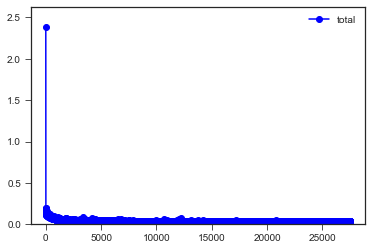

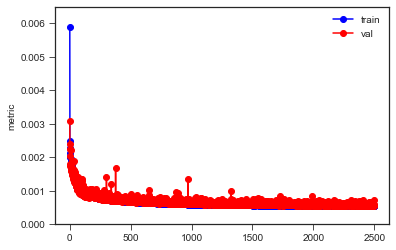

In [391]:
#########################################################################
### Training phase
#########################################################################

# Define after how many batches we should display the loss
display_loss_batch_step = 100

# Define after how many epochs we should display the metric
display_metric_epoch_step = 1

# Define the number of epochs
num_epochs = 1500

# Loop over epochs
start_time = time.time()
for epoch in range(num_epochs):
    # Initialize 'runners' to zero
    running_loss = 0.0
    num_batches  = 0
    
    # Inialize the train metric list as empty list
    metric_epoch_train_list = list()
    
    # Loop over batches
    for batch_index, (x_data, y_data) in enumerate(dataloader_dict['train']):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = net(x_data)
        
        # Calculate the loss
        loss = loss_func(y_data, y_pred)
        
        # Calculate the metric
        metric = eval_metric(y_data, y_pred)
        
        # Calculate the backward pass (and thereby set the gradients of the parameters)
        loss.backward()
        
        # Update the parameters by performing an optimizer step
        optimizer.step()
        
        # Update the number of batches and the running loss
        num_batches  += 1
        running_loss += loss.item()
        
        # Append the metric
        metric_epoch_train_list.append( metric.item() )
        
        # Display results if needed
        if batch_index%display_loss_batch_step==(display_loss_batch_step-1):
            print(f"[{epoch}-{batch_index}] Loss: {running_loss/num_batches}")
            running_losses.append(running_loss/num_batches)
            
            # Set 'runners' back to zero
            running_loss = 0.0
            num_batches  = 0
    
    # Display the epoch summary
    print('-'*70)
    print(f"Epoch {epoch} summary:")
    # Calculate the average train method for this epoch and reset the list
    metric_epoch_train = np.mean(metric_epoch_train_list)
    metric_epoch_train_list = list()
    
    # Display the train metric every epoch
    print(f"[{epoch}] Metric (train): {metric_epoch_train}")
    
    # Append the epoch's metric to the list of all train metrics
    metric_train_list.append(metric_epoch_train)

    # Evaluate the validation metric for a certain number of epochs
    if epoch%display_metric_epoch_step==(display_metric_epoch_step-1):
            # Loop over the validation batches
            metric_epoch_val_list = list()
            for batch_index, (x_data, y_data) in enumerate(dataloader_dict['val']):
                # Forward pass
                y_pred = net(x_data)

                # Evaluate the batch metric and append it
                metric = eval_metric(y_data, y_pred)
                metric_epoch_val_list.append( metric.item() )

            # Calculate the average over the batches
            metric_epoch_val = np.mean(metric_epoch_val_list)
            
            # Append the epoch's metric to the list of all validation metrics
            metric_val_list.append(metric_epoch_val)

            # Display results
            print(f"[{epoch}] Metric (val): {metric_epoch_val}")
    print('-'*70)
            
print(f"Training done (Duration: {(time.time()-start_time)/60:.2f} min)")

# Store the trained model
PATH = './logp_net.pth'
torch.save(net.state_dict(), PATH)

# Display the results
plt.figure
plt.plot(running_losses, 'bo-', label='total')
plt.ylim([0, np.max(running_losses)*1.1])
plt.legend()
plt.show()

plt.figure
plt.plot(metric_train_list, 'bo-', label='train')
plt.plot(metric_val_list, 'ro-', label='val')
plt.ylim([0, np.max(metric_train_list)*1.1])
plt.ylabel('metric')
plt.legend()
plt.show()


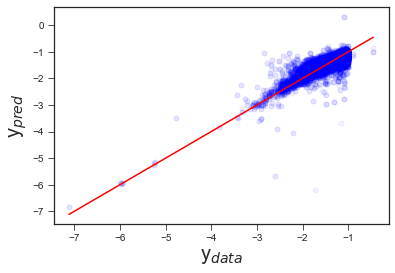

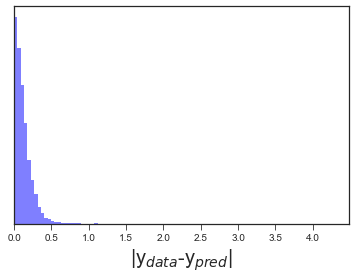

In [395]:
#########################################################################
### Evaluate results on the test set
#########################################################################
# Collect the ground truth y (y_data) and predict y (y_predict)
y_pred_list = list()
y_data_list = list()
# Make sure that no gradients are calculated
with torch.no_grad():
    # Loop over the test set
    for (x_data, y_data) in dataloader_dict['test']:
        # Predict output y
        y_pred = net(x_data)
        
        # Append to the corresponding lists
        y_pred_list.append(y_pred.detach().numpy())
        y_data_list.append(y_data.detach().numpy())
        
# Stack the arrays in the list above and apply the inverse transformation to y
# Remark: In preprocessing y is transformed as f: y_orig -> y_transformed.
#         The predicted values are in the transformed space and thus transform 
#         them back using the inverse transformation f^{-1}
y_data = dataset.inverse_transform_y( np.vstack(y_data_list).reshape(-1) )
y_pred = dataset.inverse_transform_y( np.vstack(y_pred_list).reshape(-1) )

# Display the correlations between the ground truth values and predictions
plt.figure()
plt.plot(y_data, y_pred, 'bo', alpha=0.05, ms=5)
t = np.linspace(y_data.min(), y_data.max(), 10)
plt.plot(t, t, 'r-')
plt.xlabel(r'y$_{data}$', fontsize=20)
plt.ylabel(r'y$_{pred}$', fontsize=20)
plt.show()

# Display the distribution of the absolute errors between ground truth values and predictions
plt.figure()
_hist = plt.hist(np.abs(y_data-y_pred), bins=100, color='b', density=True, alpha=0.5)
plt.xlim([0, _hist[1].max()])
plt.xlabel(r'|y$_{data}$-y$_{pred}$|', fontsize=20)
plt.yticks([])
plt.show()
